<a href="https://colab.research.google.com/github/Subibub/ML/blob/main/allstate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 보험 손해 예측 및 보험료 산출 모델링

In [1]:
!apt-get install -y libboost-all-dev
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
%cd build
!cmake -DUSE_GPU=1 ..
!make -j4
%cd ..
!python3 setup.py install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Cloning into 'LightGBM'...
remote: Enumerating objects: 35281, done.
remote: Counting objects: 100% (5418/5418), done.
remote: Compressing objects: 100% (550/550), done.
remote: Total 35281 (delta 5184), reused 4876 (delta 4867), pack-reused 29863 (from 3)
Receiving objects: 100% (35281/35281), 23.30 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (26318/26318), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https

## 1. 데이터 로딩 및 기본 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

# 경고 메시지 억제
import warnings
warnings.filterwarnings('ignore')

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


In [2]:
# 데이터 로드
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/MyDrive/Allstate/train.csv')
print(f"훈련 데이터 크기: {train_df.shape}")
train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
훈련 데이터 크기: (188318, 132)


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [3]:
#test 데이터 로드
test_df = pd.read_csv("/content/drive/MyDrive/Allstate/test.csv")
test_df['loss'] = np.nan  # 테스트셋 손실값 자리 확보
print(f"테스트 데이터 크기: {test_df.shape}")
test_df.head()

테스트 데이터 크기: (125546, 132)


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,4,A,B,A,A,A,A,A,A,B,...,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,NaN
1,6,A,B,A,B,A,A,A,A,B,...,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,NaN
2,9,A,B,A,B,B,A,B,A,B,...,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,NaN
3,12,A,A,A,A,B,A,A,A,A,...,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,NaN
4,15,B,A,A,A,A,B,A,A,A,...,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,NaN


In [4]:
# 결측치 확인
print("훈련 데이터 결측치 확인:")
print(train_df.isnull().sum())
print("테스트 데이터 결측치 확인:")
print(test_df.isnull().sum())

훈련 데이터 결측치 확인:
id        0
cat1      0
cat2      0
cat3      0
cat4      0
         ..
cont11    0
cont12    0
cont13    0
cont14    0
loss      0
Length: 132, dtype: int64
테스트 데이터 결측치 확인:
id             0
cat1           0
cat2           0
cat3           0
cat4           0
           ...  
cont11         0
cont12         0
cont13         0
cont14         0
loss      125546
Length: 132, dtype: int64


In [5]:
# 변수 타입 분리
cat_features = [col for col in train_df.columns if 'cat' in col]
cont_features = [col for col in train_df.columns if 'cont' in col]

In [6]:
# 결측치 처리 (각 열의 평균으로 대체)
for col in cont_features:
    if train_df[col].isnull().sum() > 0:
        mean_val = train_df[col].mean()
        train_df[col].fillna(mean_val, inplace=True)
        test_df[col].fillna(mean_val, inplace=True)

for col in cat_features:
    if train_df[col].isnull().sum() > 0:
        mode_val = train_df[col].mode()[0]
        train_df[col].fillna(mode_val, inplace=True)
        test_df[col].fillna(mode_val, inplace=True)


In [7]:
# 기본 통계량 확인
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,188318.0,294135.982561,169336.084867,1.000000,147748.250000,294539.500000,440680.500000,587633.000000
cont1,188318.0,0.493861,0.187640,0.000016,0.346090,0.475784,0.623912,0.984975
cont2,188318.0,0.507188,0.207202,0.001149,0.358319,0.555782,0.681761,0.862654
cont3,188318.0,0.498918,0.202105,0.002634,0.336963,0.527991,0.634224,0.944251
cont4,188318.0,0.491812,0.211292,0.176921,0.327354,0.452887,0.652072,0.954297
cont5,188318.0,0.487428,0.209027,0.281143,0.281143,0.422268,0.643315,0.983674
cont6,188318.0,0.490945,0.205273,0.012683,0.336105,0.440945,0.655021,0.997162
cont7,188318.0,0.484970,0.178450,0.069503,0.350175,0.438285,0.591045,1.000000
cont8,188318.0,0.486437,0.199370,0.236880,0.312800,0.441060,0.623580,0.980200
cont9,188318.0,0.485506,0.181660,0.000080,0.358970,0.441450,0.566820,0.995400


## 2. 탐색적 데이터 분석(EDA)

Text(0.5, 1.0, 'Loss Distribution')

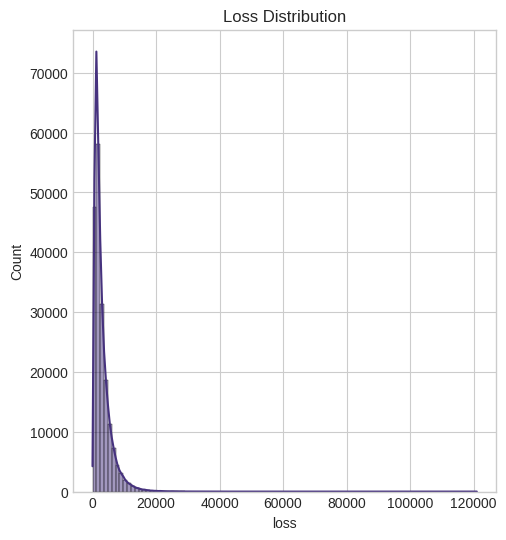

In [8]:
# 타겟 변수(loss) 분포 확인
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_df['loss'], bins=100, kde=True)
plt.title("Loss Distribution")


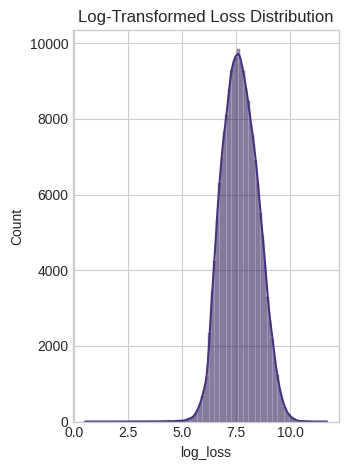

In [9]:
# 로그 변환 후 정규 분포 확인
plt.subplot(1, 2, 2)
train_df['log_loss'] = np.log1p(train_df['loss'])  # log(1 + x)
sns.histplot(train_df['log_loss'], bins=100, kde=True)
plt.title("Log-Transformed Loss Distribution")
plt.tight_layout()
plt.show()


In [10]:
# 데이터타입 확인
print(train_df.dtypes)


id            int64
cat1         object
cat2         object
cat3         object
cat4         object
             ...   
cont12      float64
cont13      float64
cont14      float64
loss        float64
log_loss    float64
Length: 133, dtype: object


In [11]:
# 범주형 변수 고유값 개수 확인
print("범주형 변수 고유값 개수:")
print(train_df[cat_features].nunique().sort_values())

범주형 변수 고유값 개수:
cat1        2
cat2        2
cat3        2
cat4        2
cat5        2
         ... 
cat112     51
cat113     61
cat109     84
cat110    131
cat116    326
Length: 116, dtype: int64


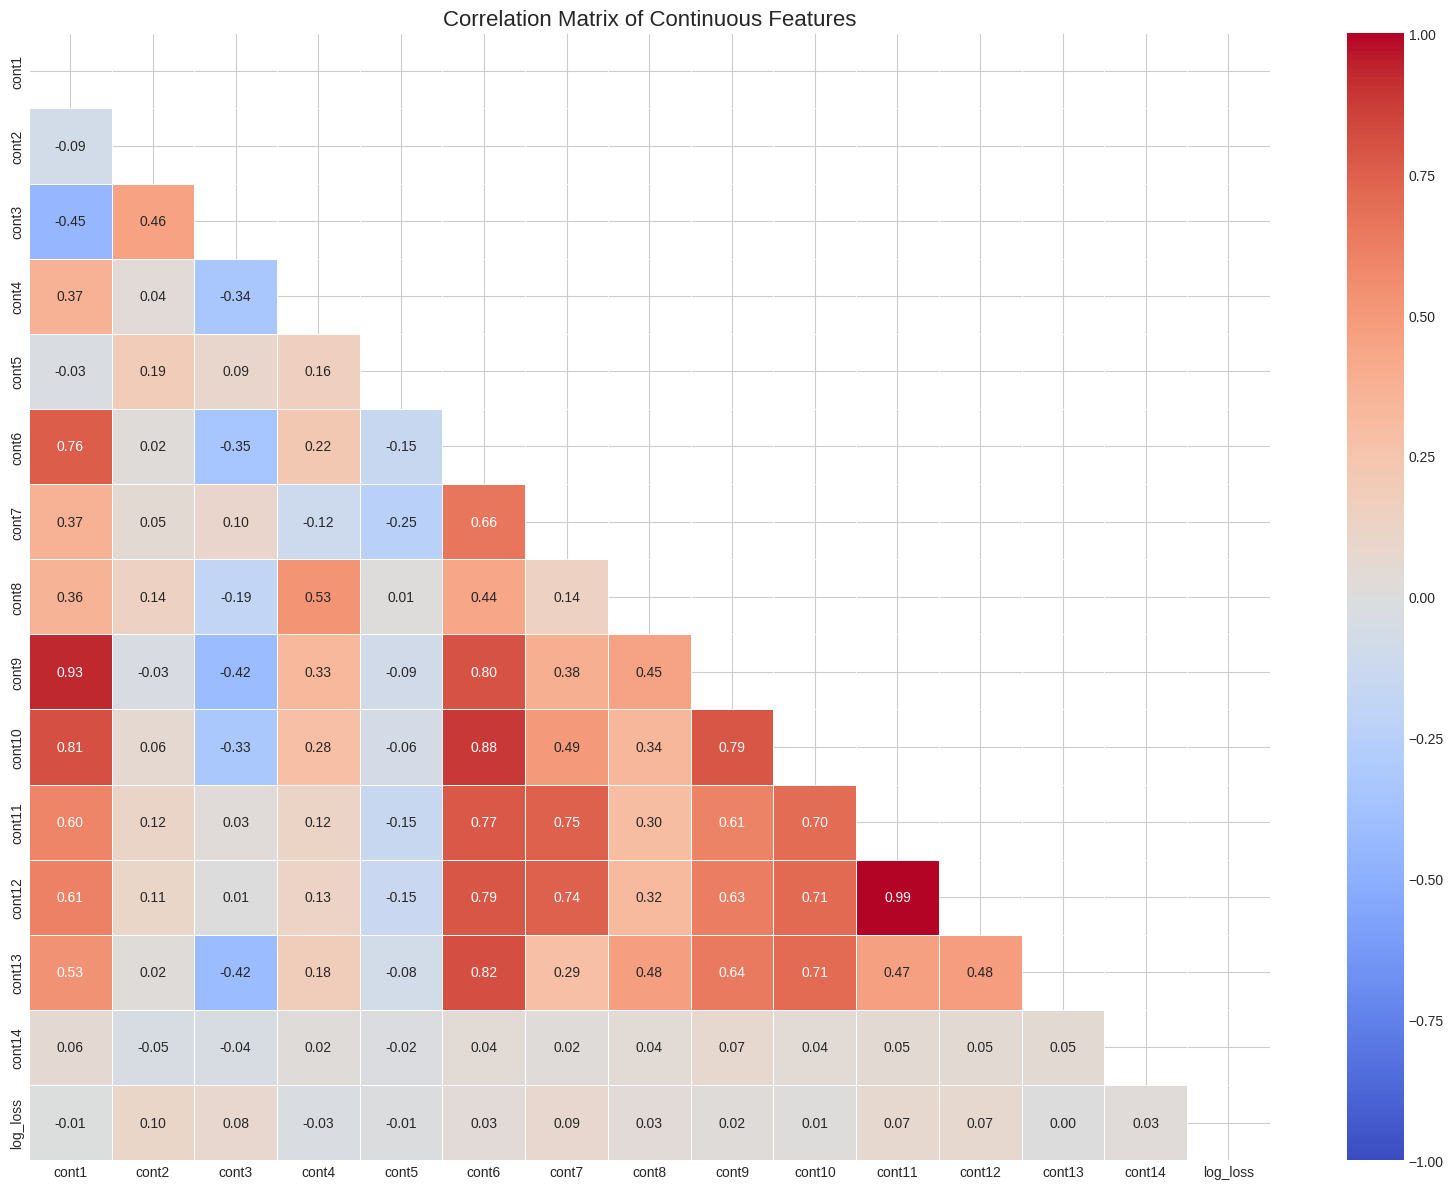

In [12]:
# 연속형 변수 상관관계 분석
plt.figure(figsize=(16, 12))
corr_matrix = train_df[cont_features + ['log_loss']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f",
            linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Continuous Features", fontsize=16)
plt.tight_layout()
plt.show()

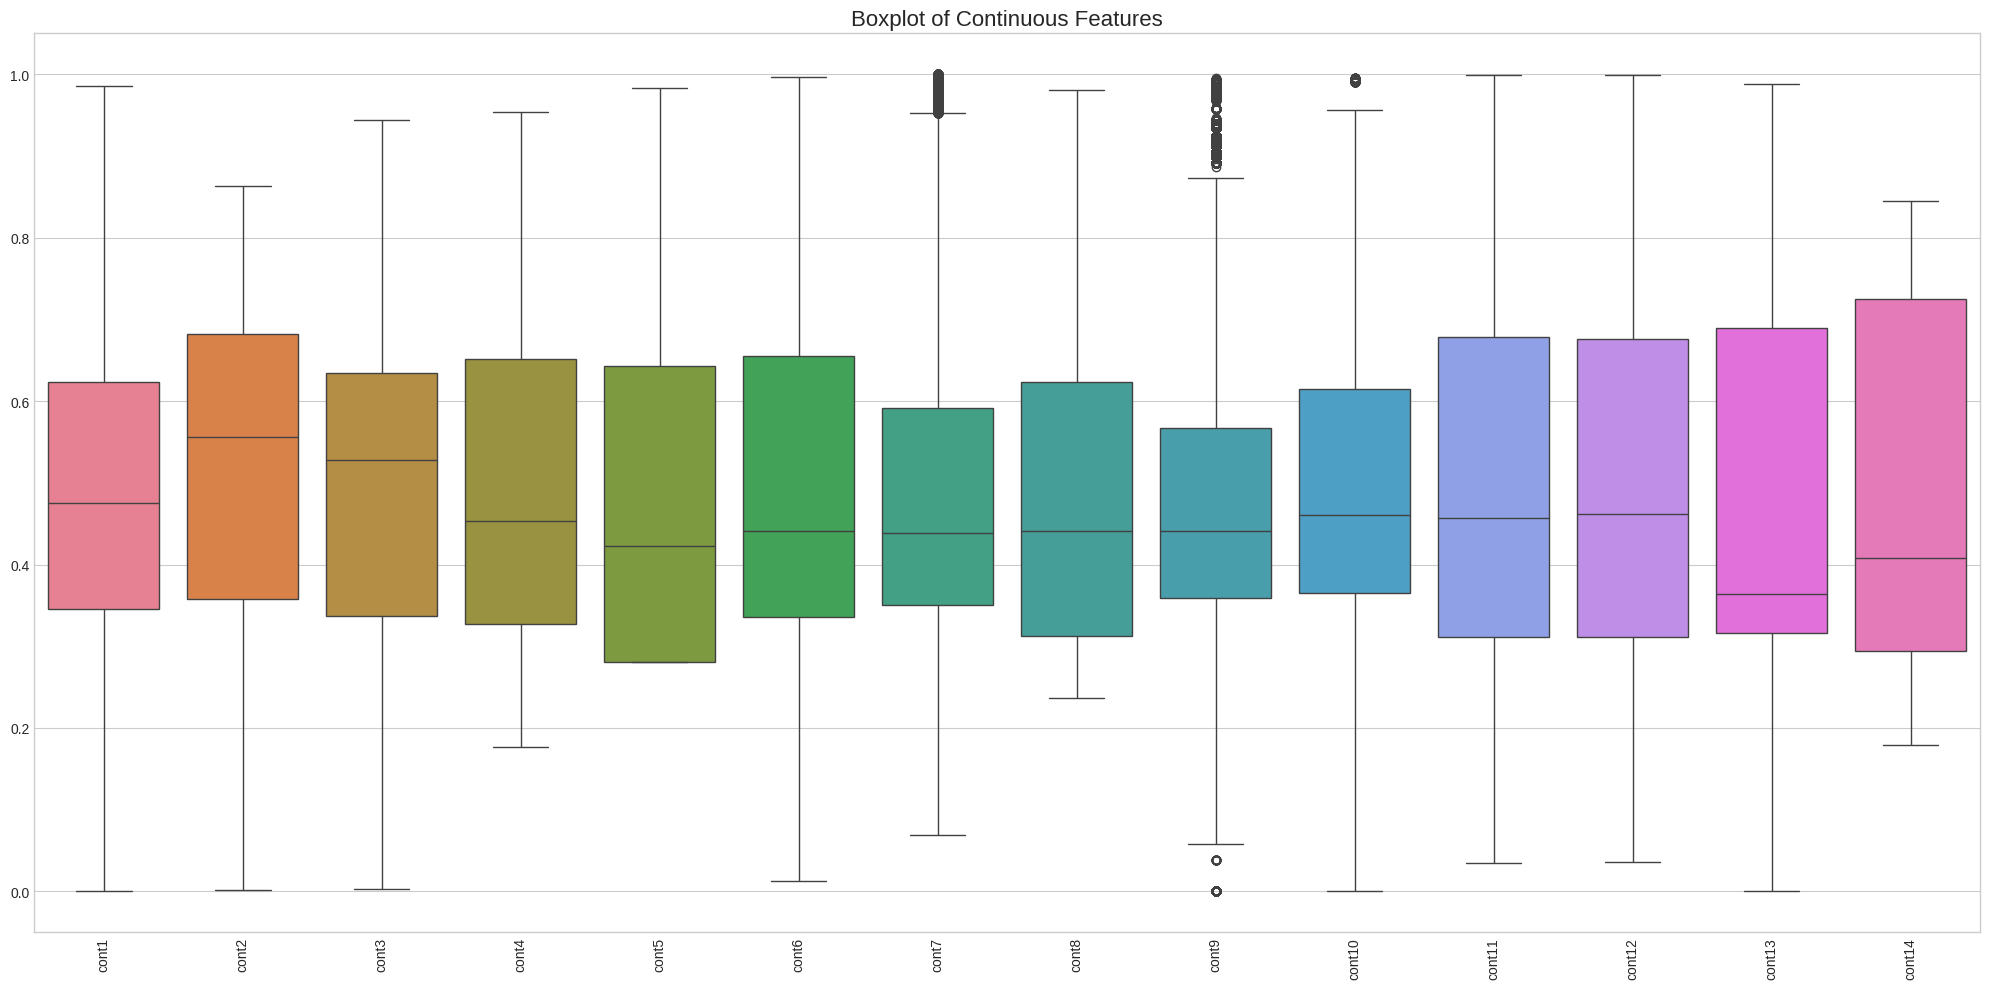

In [13]:
# 연속형 변수의 이상치 확인
plt.figure(figsize=(20, 10))
sns.boxplot(data=train_df[cont_features])
plt.xticks(rotation=90)
plt.title("Boxplot of Continuous Features", fontsize=16)
plt.tight_layout()
plt.show()


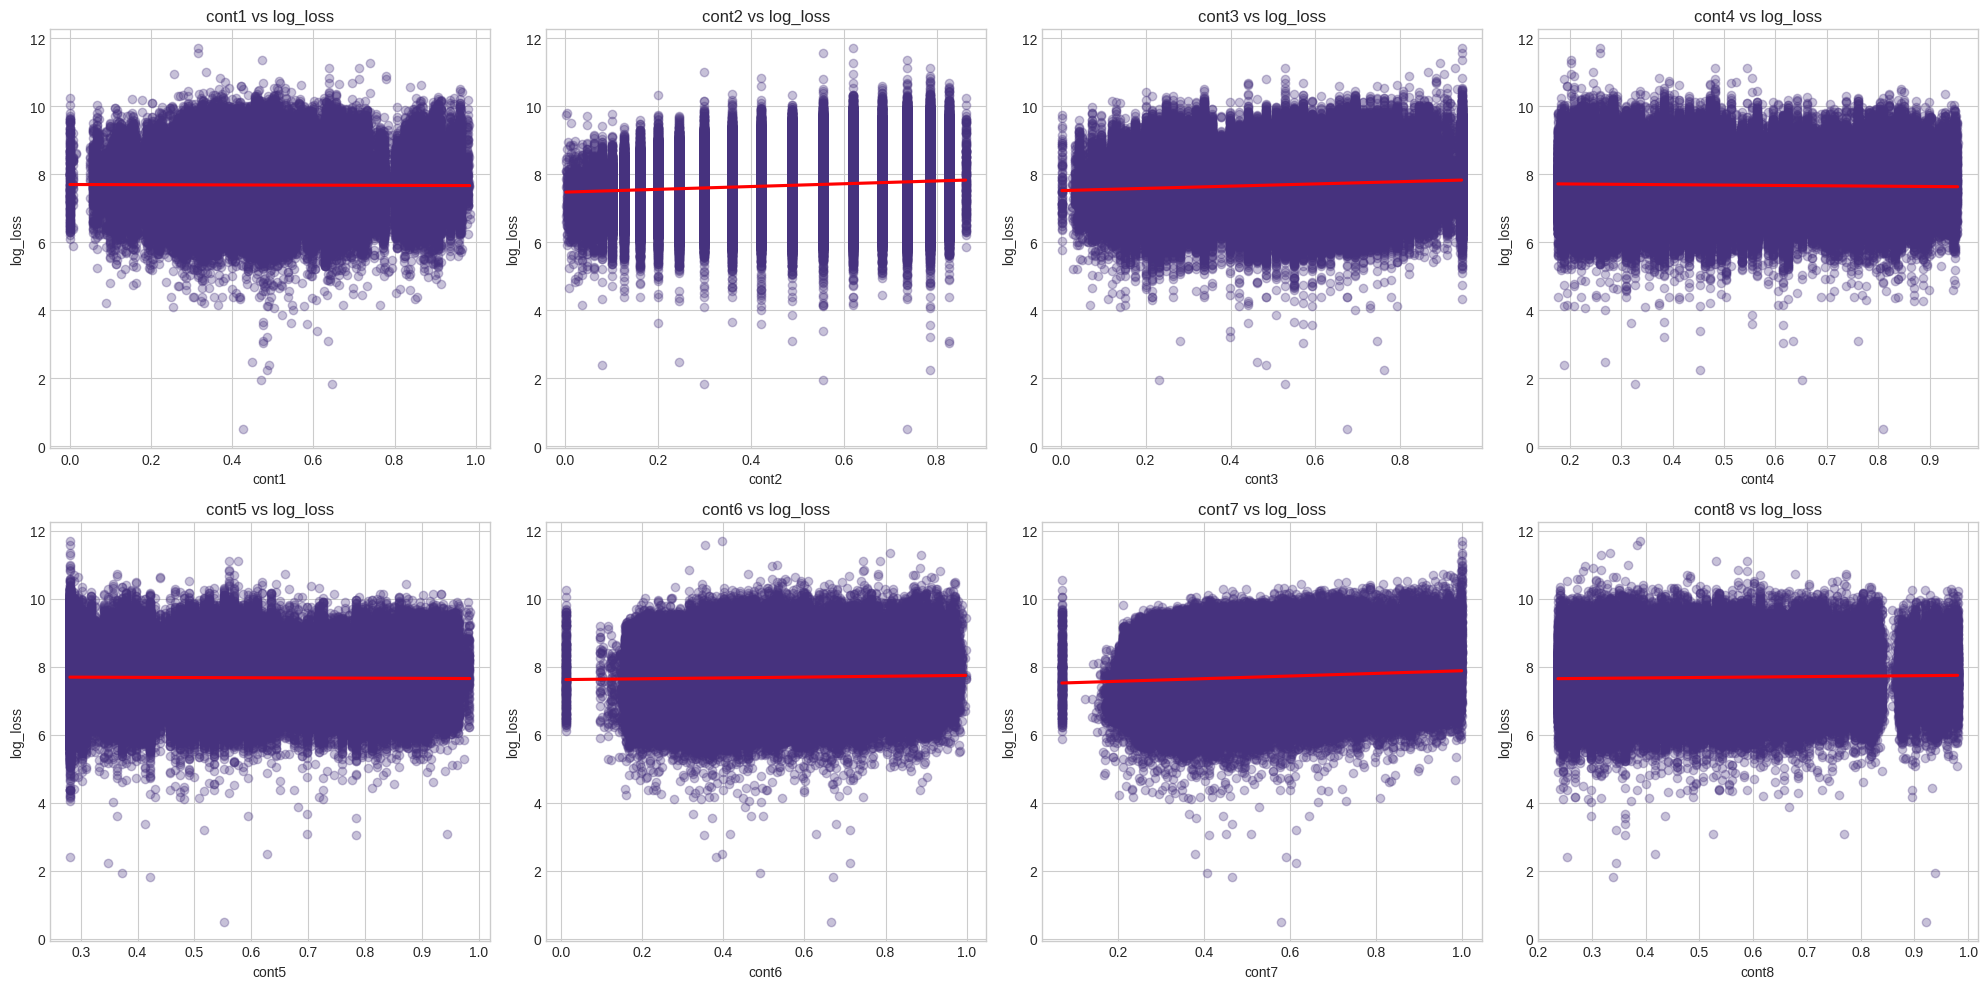

In [14]:
# 타겟 변수와 연속형 변수 간의 관계 시각화 (상위 8개만)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# 연속형 변수가 8개보다 적을 경우 오류 방지
num_plots = min(len(cont_features), 8)

for i in range(num_plots):
    col = cont_features[i]
    sns.regplot(x=train_df[col], y=train_df['log_loss'], ax=axes[i],
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    axes[i].set_title(f'{col} vs log_loss')

# 사용하지 않는 서브플롯 숨기기
for i in range(num_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

## 3. 데이터 전처리 파이프라인

In [15]:
# 훈련 및 테스트 데이터 병합
combined = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# 로그 변환 (타겟용)
combined['log_loss'] = np.log1p(combined['loss'])

# 변수 분리
cat_onehot = [f'cat{i}' for i in range(1, 51)]  # 원핫인코딩할 범주형 변수
cat_target = [col for col in cat_features if col not in cat_onehot]  # 타겟 인코딩할 범주형 변수

# 범주형 변수가 문자열인지 확인 후 변환
for col in cat_onehot:
    if combined[col].dtype != 'object':
        combined[col] = combined[col].astype(str)

# 연속형 변수 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined[cont_features] = scaler.fit_transform(combined[cont_features])

# 원핫인코딩 적용 (한 번만)
combined_onehot = pd.get_dummies(combined[cat_onehot], prefix=cat_onehot, dummy_na=False)
print(f"원핫 인코딩 적용 후 특성 개수: {combined_onehot.shape[1]}")

원핫 인코딩 적용 후 특성 개수: 100


In [17]:
'''
# 3. 연속형 변수만 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined[cont_features] = scaler.fit_transform(combined[cont_features])

# 4. 범주형 변수에 대해 원핫인코딩 확실히 적용
combined_onehot = pd.get_dummies(combined[cat_features])

# 5. 모델 입력 데이터 구성 (특성 타입 구분)
X_full = pd.concat([
    combined[cont_features],  # 스케일링된 연속형 변수
    combined_onehot,          # 원핫인코딩된 범주형 변수
], axis=1)
'''

In [18]:
'''
# 원핫 인코딩 (cat1 ~ cat50)
print("원핫 인코딩 적용...")
# 범주형 변수가 문자열인지 확인 후 변환
for col in cat_onehot:
    if combined[col].dtype != 'object':
        combined[col] = combined[col].astype(str)

combined_onehot = pd.get_dummies(combined[cat_onehot], prefix=cat_onehot, dummy_na=False)
print(f"원핫 인코딩 적용 후 특성 개수: {combined_onehot.shape[1]}")
'''


원핫 인코딩 적용...
원핫 인코딩 적용 후 특성 개수: 100


In [16]:
# 타겟 인코딩 (cat51 이상)
print("타겟 인코딩 적용...")
train_part = combined.iloc[:len(train_df)]

target_encoded_cols = []
for col in cat_target:
    # 각 범주별 타겟의 평균값 계산
    mapping = train_part.groupby(col)['log_loss'].mean().to_dict()
    global_mean = train_part['log_loss'].mean()
    # 매핑 적용 및 모든 범주에 존재하지 않는 값은 글로벌 평균으로 대체
    combined[f'{col}_encoded'] = combined[col].map(mapping).fillna(global_mean)
    target_encoded_cols.append(f'{col}_encoded')


타겟 인코딩 적용...


In [17]:
# 연속형 변수 이상치 처리 및 변환
print("연속형 변수 전처리 적용...")

# NaN 값 체크 및 처리
for col in cont_features:
    if combined[col].isnull().sum() > 0:
        combined[col].fillna(combined[col].mean(), inplace=True)

# 이상치가 많은 열만 선택적으로 Winsorization 적용
for col in ['cont9', 'cont10', 'cont11', 'cont12', 'cont13']:
    # NaN 값이 없는지 확인 후 winsorize 적용
    if not np.isnan(combined[col]).any():
        combined[col] = np.array(winsorize(combined[col], limits=[0.01, 0.01]))

# 왜도가 높은 변수에 로그 변환 적용
skewed_cols = ['cont5', 'cont3', 'cont11']
for col in skewed_cols:
    # 음수 값이 있는지 확인
    min_val = combined[col].min()
    if min_val < 0:
        combined[col] = np.log1p(combined[col] - min_val + 1)  # 음수 값 조정
    else:
        combined[col] = np.log1p(combined[col])

# 연속형 변수 정규화 (한 번만 수행)
scaler = StandardScaler()
combined[cont_features] = scaler.fit_transform(combined[cont_features])



연속형 변수 전처리 적용...


In [18]:
# 최종 입력값 생성
X_full = pd.concat([
    combined[cont_features],          # 스케일링된 연속형 변수
    combined_onehot,                  # 원핫인코딩된 범주형 변수
    combined[target_encoded_cols]     # 타겟인코딩된 범주형 변수
], axis=1)

# 모든 컬럼에 대해 결측치 확인
na_cols = X_full.columns[X_full.isna().any()].tolist()
if na_cols:
    print(f"결측치가 있는 컬럼: {na_cols}")
    # 결측치 처리
    for col in na_cols:
        X_full[col].fillna(X_full[col].mean() if X_full[col].dtype.kind in 'fc' else 0, inplace=True)

# 다시 train/test 분리 (인덱싱 수정)
X_train = X_full.iloc[:len(train_df)]
y_train = combined.iloc[:len(train_df)]['log_loss'].copy()

# NaN 값 확인 및 제거
if y_train.isnull().sum() > 0:
    print(f"타겟 변수에 {y_train.isnull().sum()}개의 NaN 값이 있습니다. 평균값으로 대체합니다.")
    y_train.fillna(y_train.mean(), inplace=True)

X_test = X_full.iloc[len(train_df):]

# 차원 확인 (X_train과 y_train 길이가 같은지 확인)
print(f"X_train 차원: {X_train.shape}")
print(f"y_train 차원: {y_train.shape}")
print(f"X_test 차원: {X_test.shape}")

X_train 차원: (188318, 180)
y_train 차원: (188318,)
X_test 차원: (125546, 180)


## 4. 모델 선택 및 성능 평가


In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


In [20]:
# 검증용으로 train 세트 분할
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [21]:
# 여러 모델 테스트 (일부 파라미터 조정)
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.1, random_state=42, max_iter=1000),  # max_iter 추가
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),  # n_jobs 추가
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),  # n_jobs 추가
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)  # n_jobs 추가
}

# 결과 저장용 딕셔너리
results = {}

# 모델 훈련 및 평가
for name, model in models.items():
    print(f"{name} 모델 학습 중...")
    model.fit(X_tr, y_tr)

    # 예측 (로그 스케일)
    pred_log = model.predict(X_val)

    # 로그 스케일 평가 지표
    mae_log = mean_absolute_error(y_val, pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_val, pred_log))
    r2_log = r2_score(y_val, pred_log)

    # 원래 스케일로 변환 후 평가 지표
    pred_loss = np.expm1(pred_log)
    true_loss = np.expm1(y_val)
    mae_real = mean_absolute_error(true_loss, pred_loss)

    results[name] = {
        "log_mae": round(mae_log, 4),
        "log_rmse": round(rmse_log, 4),
        "log_r2": round(r2_log, 4),
        "real_mae": round(mae_real, 2)
    }

# 결과 출력
print("\n모델 성능 비교:")
for model, res in results.items():
    print(f"{model:15s} | Log MAE: {res['log_mae']:.4f} | Log RMSE: {res['log_rmse']:.4f} | R²: {res['log_r2']:.4f} | Real MAE: {res['real_mae']:.2f}")


Linear 모델 학습 중...
Ridge 모델 학습 중...
Lasso 모델 학습 중...
RandomForest 모델 학습 중...
GradientBoosting 모델 학습 중...
XGBoost 모델 학습 중...
LightGBM 모델 학습 중...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3712
[LightGBM] [Info] Number of data points in the train set: 150654, number of used features: 180
[LightGBM] [Info] Start training from score 7.685676

모델 성능 비교:
Linear          | Log MAE: 0.4435 | Log RMSE: 0.5652 | R²: 0.5104 | Real MAE: 1255.94
Ridge           | Log MAE: 0.4435 | Log RMSE: 0.5651 | R²: 0.5105 | Real MAE: 1255.91
Lasso           | Log MAE: 0.6081 | Log RMSE: 0.7485 | R²: 0.1411 | Real MAE: 1681.35
RandomForest    | Log MAE: 0.4344 | Log RMSE: 0.5584 | R²: 0.5220 | Real MAE: 1197.49
GradientBoosting | Log MAE: 0.4334 | Log RMSE: 0.5553 | R²: 0.5273 | Real MAE: 1192.25
XGBoost

In [22]:
# 가장 우수한 모델에 대한 K-Fold 교차 검증
best_model_name = min(results, key=lambda x: results[x]['log_mae'])
best_model = models[best_model_name]  # 클래스 대신 인스턴스 사용

print(f"\n최고 성능 모델: {best_model_name}")

# 5-Fold 교차 검증
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

for train_idx, val_idx in kf.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # 모델 복제 및 학습
    from sklearn.base import clone
    fold_model = clone(best_model)
    fold_model.fit(X_fold_train, y_fold_train)

    # 예측 및 MAE 계산
    y_pred = fold_model.predict(X_fold_val)
    mae = mean_absolute_error(y_fold_val, y_pred)
    mae_scores.append(mae)

print("5-Fold 교차 검증 MAE 점수:")
print(mae_scores)
print(f"평균 MAE: {np.mean(mae_scores):.4f}")
print(f"표준편차: {np.std(mae_scores):.4f}")



최고 성능 모델: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3712
[LightGBM] [Info] Number of data points in the train set: 150654, number of used features: 180
[LightGBM] [Info] Start training from score 7.685676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3724
[LightGBM] [Info] Number of data points in the train set: 150654, number of used features: 180
[LightGBM] [Info] Start training from score 7.685940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135945 seconds.
You can set `force_row_wise=true` to remove the overhead.
An

In [30]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.5 MB/s eta 0:00:00


In [33]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 30)
    }

    model = LGBMRegressor(**params, random_state=42, n_jobs=-1, verbose = -1)

    # 교차 검증 점수 (MAE, 낮을수록 좋음)
    score = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=3
    )
    return -score.mean()

# 스터디 생성 및 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # 30번 실험 (필요 시 늘려도 OK)

# 결과 출력
print("\n✅ 최적 파라미터:")
for param, val in study.best_trial.params.items():
    print(f"{param}: {val}")
print(f"✅ Best CV MAE: {study.best_value:.4f}")

[I 2025-04-05 03:54:16,498] A new study created in memory with name: no-name-8d0a6092-a3f5-410d-8837-eb6ec173ced7
[I 2025-04-05 03:54:35,990] Trial 0 finished with value: 0.43669686204427377 and parameters: {'n_estimators': 126, 'learning_rate': 0.07513999558694481, 'max_depth': 3, 'num_leaves': 31, 'subsample': 0.9973875574996665, 'colsample_bytree': 0.8186964104366858, 'min_child_samples': 14}. Best is trial 0 with value: 0.43669686204427377.
[I 2025-04-05 03:55:16,658] Trial 1 finished with value: 0.4215744473220209 and parameters: {'n_estimators': 366, 'learning_rate': 0.19843003627846653, 'max_depth': 9, 'num_leaves': 68, 'subsample': 0.9752982837876312, 'colsample_bytree': 0.751390085276041, 'min_child_samples': 27}. Best is trial 1 with value: 0.4215744473220209.
[I 2025-04-05 03:55:37,644] Trial 2 finished with value: 0.41959866720729405 and parameters: {'n_estimators': 114, 'learning_rate': 0.09847014983149659, 'max_depth': 10, 'num_leaves': 27, 'subsample': 0.737825347890861,


✅ 최적 파라미터:
n_estimators: 786
learning_rate: 0.04937619698271257
max_depth: 10
num_leaves: 68
subsample: 0.9081677695782933
colsample_bytree: 0.7063405594543548
min_child_samples: 30
✅ Best CV MAE: 0.4147


In [35]:
from lightgbm import LGBMRegressor
import numpy as np

#  1. 샘플 가중치 생성 (로그 손해액 → 원래 손해액 복원 기준)
sample_weights = np.expm1(y_train)
sample_weights = sample_weights / sample_weights.mean()  # 정규화 (선택)

# 2. 최적 파라미터로 모델 생성
final_model = LGBMRegressor(
    n_estimators=786,
    learning_rate=0.04937619698271257,
    max_depth=10,
    num_leaves=68,
    subsample=0.9081677695782933,
    colsample_bytree=0.7063405594543548,
    min_child_samples=30,
    random_state=42,
    n_jobs=-1
)

#  3. 전체 데이터로 학습
print("📦 최종 LightGBM 모델 학습 중 (샘플 가중치 포함)...")
final_model.fit(X_train, y_train, sample_weight=sample_weights)

# 4. 테스트 데이터 예측 (로그 스케일 → 원래 손해액으로 복원)
print("📈 테스트 세트 예측 중...")
log_predictions = final_model.predict(X_test)
final_predictions = np.expm1(log_predictions)  # 로그 복원

print(f"✅ 예측 완료! 총 {len(final_predictions):,}건")

📦 최종 LightGBM 모델 학습 중 (샘플 가중치 포함)...
📈 테스트 세트 예측 중...
✅ 예측 완료! 총 125,546건


In [37]:
import joblib

joblib.dump(final_model, 'final_model_lgbm.pkl')
print(" 최종 모델 저장 완료: final_model_lgbm.pkl")

 최종 모델 저장 완료: final_model_lgbm.pkl


In [38]:
with open("log.txt", "w") as f:
    f.write(" 최종 LightGBM 하이퍼파라미터\n")
    f.write("n_estimators: 786\n")
    f.write("learning_rate: 0.04937619698271257\n")
    f.write("max_depth: 10\n")
    f.write("num_leaves: 68\n")
    f.write("subsample: 0.9081677695782933\n")
    f.write("colsample_bytree: 0.7063405594543548\n")
    f.write("min_child_samples: 30\n")
    f.write("\nBest CV MAE: 0.4147\n")
    f.write("최종 예측 수: %d\n" % len(final_predictions))
print(" 로그 저장 완료: log.txt")

 로그 저장 완료: log.txt


In [40]:
submission = pd.DataFrame({
    'id': range(len(final_predictions)),
    'predicted_loss': final_predictions
})
submission.to_csv('submission.csv', index=False)
print(" 예측 결과 저장 완료: submission.csv")

 예측 결과 저장 완료: submission.csv


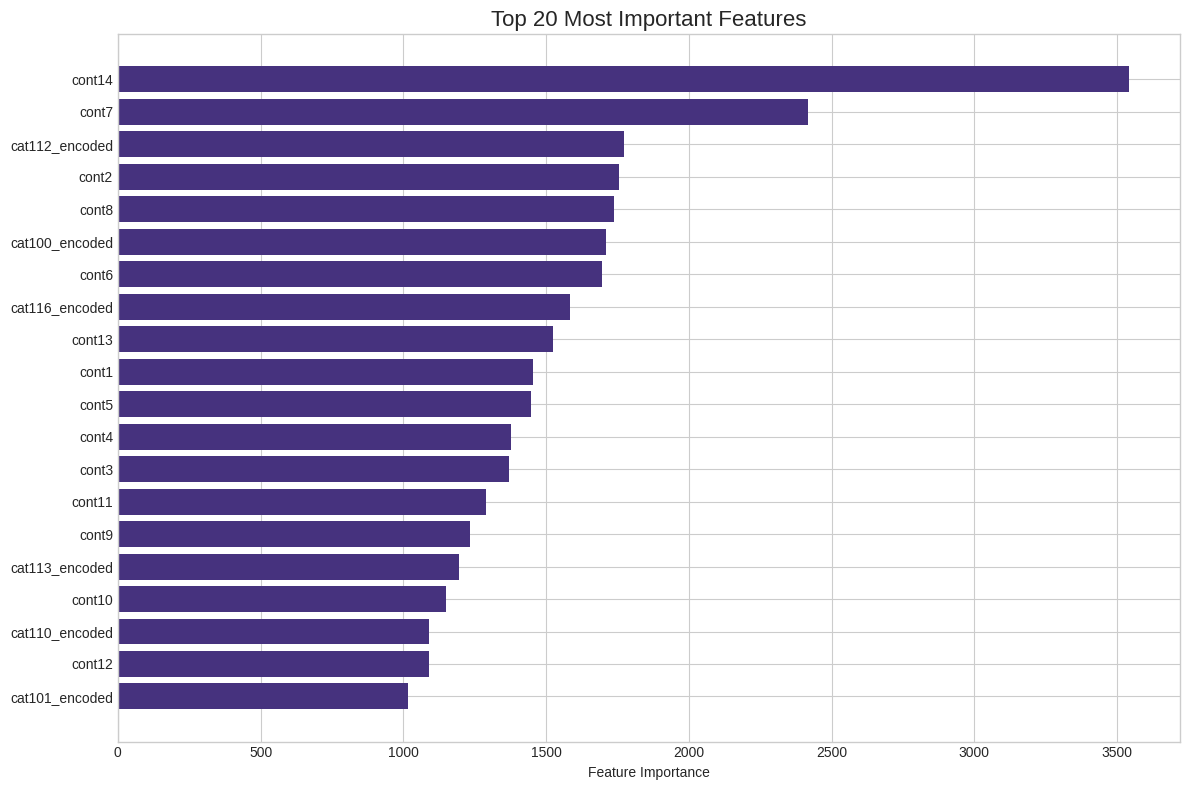

In [41]:
# 특성 중요도 시각화
plt.figure(figsize=(12, 8))
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

# 상위 20개 특성만 시각화
top_n = 20
top_features = X_full.columns[sorted_idx[-top_n:]]
top_importances = feature_importance[sorted_idx[-top_n:]]

plt.barh(range(top_n), top_importances)
plt.yticks(range(top_n), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features', fontsize=16)
plt.tight_layout()
plt.show()


SHAP 값을 이용한 모델 해석 중...


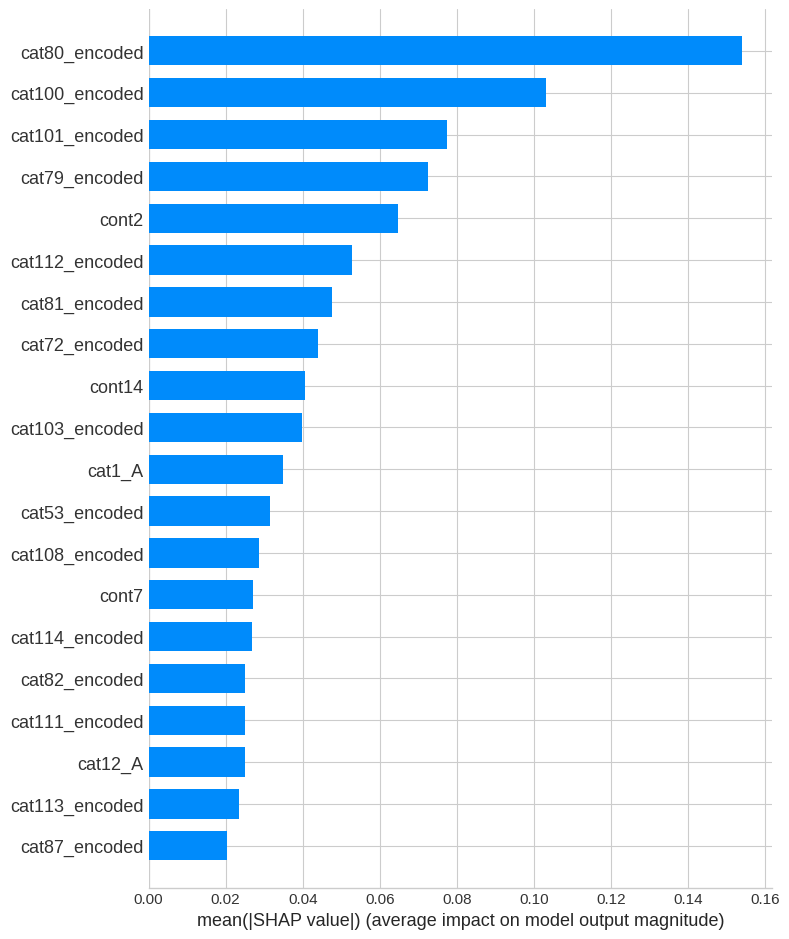

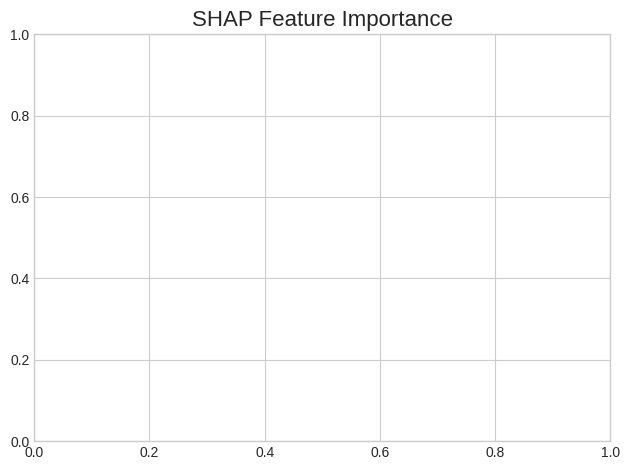

<Figure size 1000x600 with 0 Axes>

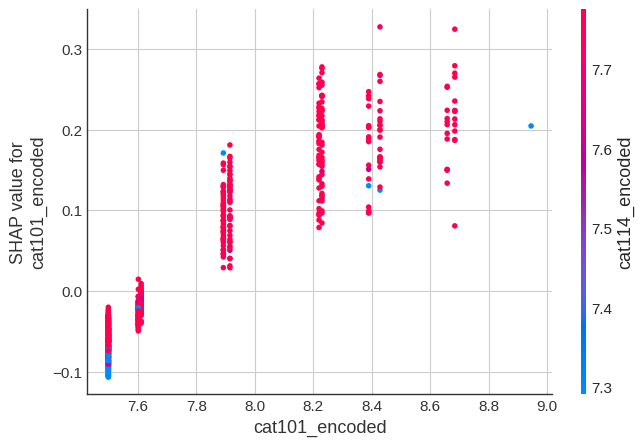

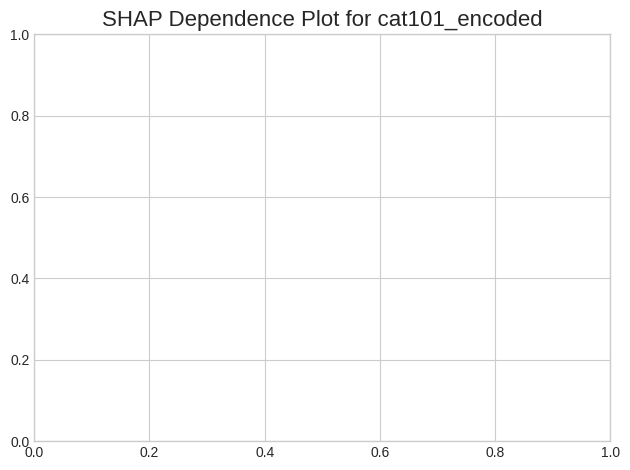

<Figure size 1000x600 with 0 Axes>

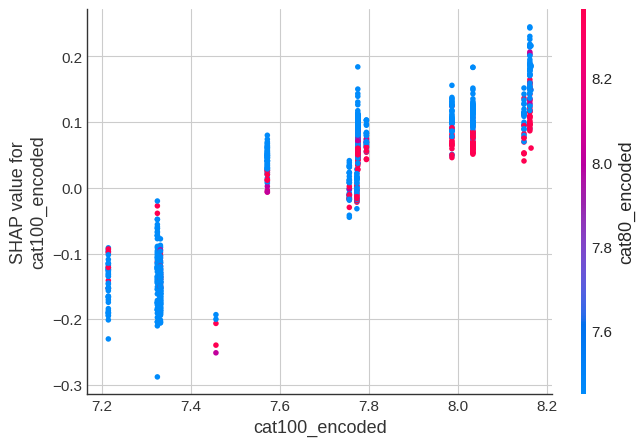

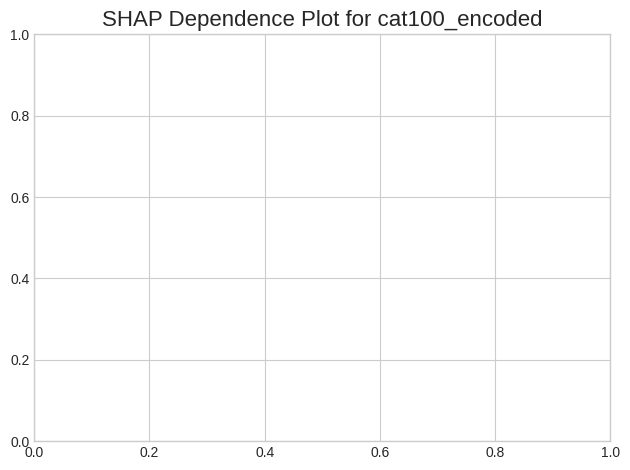

<Figure size 1000x600 with 0 Axes>

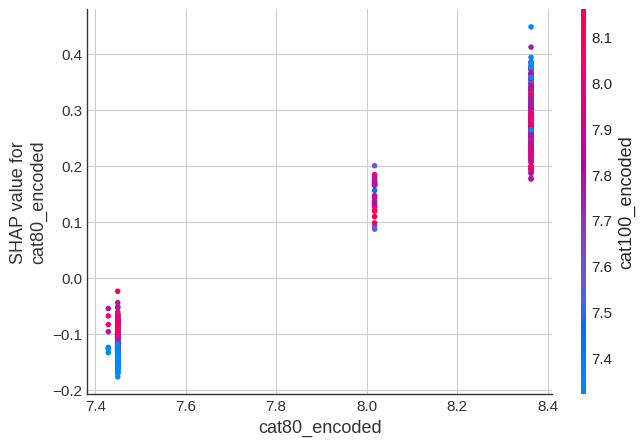

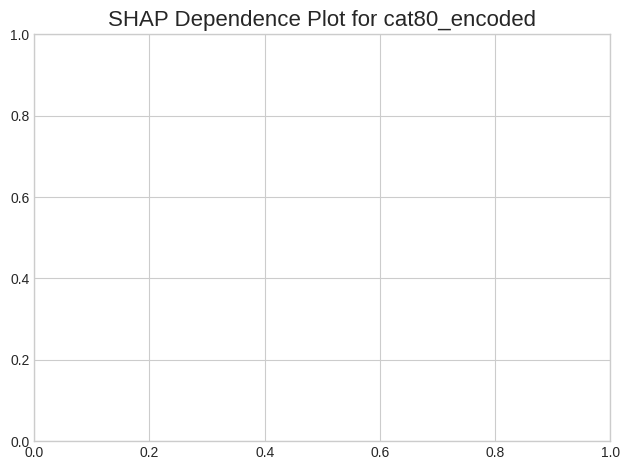

In [42]:
# SHAP 값을 이용한 심층 분석 (선택 사항)
try:
    import shap
    print("\nSHAP 값을 이용한 모델 해석 중...")

    # SHAP 값 계산 (샘플 1000개로 제한하여 계산 속도 향상)
    explainer = shap.TreeExplainer(final_model)
    shap_sample = X_full.sample(min(1000, len(X_full)), random_state=42)
    shap_values = explainer.shap_values(shap_sample)

    # SHAP 요약 플롯
    plt.figure(figsize=(10, 12))
    shap.summary_plot(shap_values, shap_sample, plot_type="bar")
    plt.title("SHAP Feature Importance", fontsize=16)
    plt.tight_layout()
    plt.show()

    # SHAP 의존성 플롯 (상위 3개 특성에 대해)
    top_3_features = X_full.columns[np.argsort(np.abs(shap_values).mean(0))[-3:]]
    for feature in top_3_features:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(feature, shap_values, shap_sample)
        plt.title(f"SHAP Dependence Plot for {feature}", fontsize=16)
        plt.tight_layout()
        plt.show()

except ImportError:
    print("SHAP 라이브러리가 설치되지 않아 건너뜁니다. 더 자세한 해석을 원하시면 'pip install shap'를 실행하세요.")


In [43]:
# 예측 결과 데이터프레임 생성
submission = pd.DataFrame({
    'id': X_test.index,  # 또는 별도의 id 컬럼이 있다면 그것을 사용
    'predicted_loss': final_predictions
})

# CSV 파일로 저장
submission.to_csv('allstate_loss_prediction.csv', index=False)
print("📄 예측 결과가 'allstate_loss_prediction.csv'에 저장되었습니다.")

# 테스트 데이터에 예측값 추가하여 보험료 산출에 사용
X_test_with_pred = X_test.copy()
X_test_with_pred['predicted_loss'] = final_predictions

# 모델 저장 (나중에 다시 사용할 수 있도록)
import joblib
joblib.dump(final_model, 'final_weighted_xgboost_model.pkl')
print("📦 최종 모델이 'final_weighted_xgboost_model.pkl'로 저장되었습니다.")

print("\n✅ 테스트 세트 예측 완료, 보험료 산출 모듈로 데이터 전달 준비")

📄 예측 결과가 'allstate_loss_prediction.csv'에 저장되었습니다.
📦 최종 모델이 'final_weighted_xgboost_model.pkl'로 저장되었습니다.

✅ 테스트 세트 예측 완료, 보험료 산출 모듈로 데이터 전달 준비


In [45]:
# 테스트 데이터 예측 (로그 스케일)
test_pred_log = final_model.predict(X_test)

# 원래 스케일로 변환
test_pred_loss = np.expm1(test_pred_log)

## 5.보험 모델링 심층 분석 및 실험

### 1. 고급 특성 엔지니어링 실험

#### 1.1 상호작용 특성(Interaction Features) 실험

In [79]:
# 상위 상관관계를 가진 연속형 변수들 간의 상호작용 특성 생성
top_cont_features = ['cont1', 'cont6', 'cont9', 'cont10', 'cont11', 'cont12']  # 예시 - 실제 분석 결과에 따라 수정

# 상호작용 특성 생성
for i in range(len(top_cont_features)):
    for j in range(i+1, len(top_cont_features)):
        feat_i = top_cont_features[i]
        feat_j = top_cont_features[j]
        interaction_name = f"{feat_i}_x_{feat_j}"
        X_train[interaction_name] = X_train[feat_i] * X_train[feat_j]
        X_val[interaction_name] = X_val[feat_i] * X_val[feat_j]
        X_test[interaction_name] = X_test[feat_i] * X_test[feat_j]

print(f"상호작용 특성 추가 후 특성 수: {X_train.shape[1]}")


상호작용 특성 추가 후 특성 수: 197


In [80]:
# 기준 모델로 LightGBM 사용
base_model = LGBMRegressor(random_state=42)
base_model.fit(X_train, y_train)

base_pred = base_model.predict(X_val)
base_mae = mean_absolute_error(y_val, base_pred)

print(f"📌 LightGBM 기준 모델 MAE: {base_mae:.4f}")

📌 LightGBM 기준 모델 MAE: 0.4101


In [81]:
# 상호작용 특성을 포함한 모델 평가

interaction_model = LGBMRegressor(n_estimators=50, random_state=42)
interaction_model.fit(X_train, y_train)
interaction_pred = interaction_model.predict(X_val)
interaction_mae = mean_absolute_error(y_val, interaction_pred)

print(f"상호작용 특성 포함 모델 MAE: {interaction_mae:.4f}")
print(f"기준 모델 MAE와의 차이: {(interaction_mae - base_mae) / base_mae * 100:.2f}%")


상호작용 특성 포함 모델 MAE: 0.4211
기준 모델 MAE와의 차이: 2.70%


#### 1.2 다항식 특성(Polynomial Features) 실험

In [82]:
def get_important_cont_features(X, y, top_n=5):
    # 연속형 변수 리스트 추정 (cont1 ~ cont14)
    cont_features = [col for col in X.columns if col.startswith("cont")]

    # 데이터 샘플링 (빠른 훈련용)
    X_sample, _, y_sample, _ = train_test_split(X[cont_features], y, test_size=0.8, random_state=42)

    # 간단한 LGBM 모델로 학습
    temp_model = LGBMRegressor(n_estimators=50, random_state=42)
    temp_model.fit(X_sample, y_sample)

    # 중요도 추출 및 정렬
    importance_df = pd.DataFrame({
        'feature': cont_features,
        'importance': temp_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    top_features = importance_df.head(top_n)['feature'].tolist()
    return top_features

In [83]:
important_cont_features = get_important_cont_features(X_train, y_train, top_n=5)
print("중요 연속형 변수:", important_cont_features)

중요 연속형 변수: ['cont14', 'cont7', 'cont2', 'cont4', 'cont13']


In [84]:
# 중요 연속형 변수에 대해 2차 다항식 특성 생성
important_features = ['cont2', 'cont7', 'cont14']

# 다항식 특성 생성기
poly = PolynomialFeatures(degree=2, include_bias=False)

# 선택된 특성에 대해서만 다항식 특성 적용
X_train_selected = X_train[important_features].copy()
X_val_selected = X_val[important_features].copy()
X_test_selected = X_test[important_features].copy()

# 다항식 생성
poly_features_train = poly.fit_transform(X_train_selected)
poly_features_val = poly.transform(X_val_selected)
poly_features_test = poly.transform(X_test_selected)

# 정확한 이름 자동 추출
poly_feature_names = poly.get_feature_names_out(important_features)[len(important_features):]

# DataFrame 변환
poly_df_train = pd.DataFrame(poly_features_train[:, len(important_features):], columns=poly_feature_names, index=X_train.index)
poly_df_val = pd.DataFrame(poly_features_val[:, len(important_features):], columns=poly_feature_names, index=X_val.index)
poly_df_test = pd.DataFrame(poly_features_test[:, len(important_features):], columns=poly_feature_names, index=X_test.index)

# 원래 특성과 결합
X_train_poly = pd.concat([X_train, poly_df_train], axis=1)
X_val_poly = pd.concat([X_val, poly_df_val], axis=1)
X_test_poly = pd.concat([X_test, poly_df_test], axis=1)

print(f"다항식 특성 추가 후 특성 수: {X_train_poly.shape[1]}")

# 다항식 특성을 포함한 모델 평가
poly_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
poly_model.fit(X_train_poly, y_train)
poly_pred = poly_model.predict(X_val_poly)
poly_mae = mean_absolute_error(y_val, poly_pred)

print(f"다항식 특성 포함 모델 MAE: {poly_mae:.4f}")
print(f"기준 모델 MAE와의 차이: {(poly_mae - base_mae) / base_mae * 100:.2f}%")


다항식 특성 추가 후 특성 수: 203
다항식 특성 포함 모델 MAE: 0.4318
기준 모델 MAE와의 차이: 5.31%


#### 1.3 특성 변환 및 이상치 처리 영향 분석

yeo-johnson 변환 MAE: 0.4304
quantile 변환 MAE: 0.4300
robust 변환 MAE: 0.4304


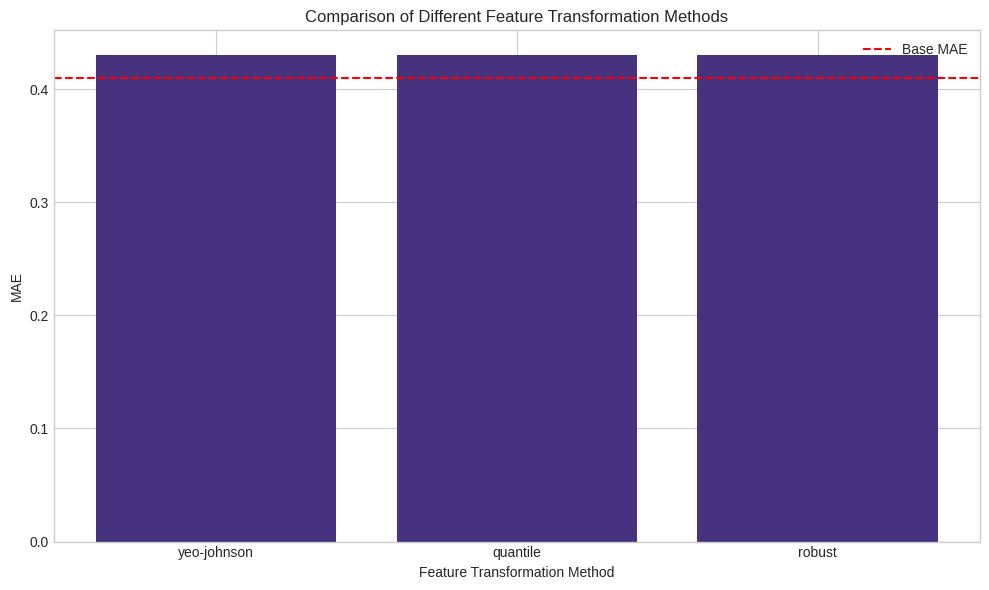

In [85]:
# 다양한 변환 방법의 영향 실험
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler

# 변환기 목록
transformers = {
    'yeo-johnson': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(output_distribution='normal'),
    'robust': RobustScaler(),
}

# 모델 성능 결과 저장
transform_results = {}

# 각 변환 방법으로 실험
for name, transformer in transformers.items():
    # 연속형 특성에만 변환 적용
    X_train_transformed = X_train.copy()
    X_val_transformed = X_val.copy()

    X_train_transformed[cont_features] = transformer.fit_transform(X_train[cont_features])
    X_val_transformed[cont_features] = transformer.transform(X_val[cont_features])

    # 변환된 데이터로 모델 학습
    transform_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    transform_model.fit(X_train_transformed, y_train)
    transform_pred = transform_model.predict(X_val_transformed)
    transform_mae = mean_absolute_error(y_val, transform_pred)

    transform_results[name] = transform_mae
    print(f"{name} 변환 MAE: {transform_mae:.4f}")

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.bar(transform_results.keys(), transform_results.values())
plt.axhline(y=base_mae, color='r', linestyle='--', label='Base MAE')
plt.xlabel('Feature Transformation Method')
plt.ylabel('MAE')
plt.title('Comparison of Different Feature Transformation Methods')
plt.legend()
plt.tight_layout()
plt.show()


### 2. 모델 앙상블 및 스태킹 실험
#### 2.1 기본 모델 가중 앙상블

GradientBoosting 모델 학습 중...
GradientBoosting 모델 MAE: 0.4674
XGBoost 모델 학습 중...
XGBoost 모델 MAE: 0.4351
LightGBM 모델 학습 중...
LightGBM 모델 MAE: 0.4376
앙상블_1 MAE: 0.4358 | 조합: {'XGBoost': 0.5, 'LightGBM': 0.5}
앙상블_2 MAE: 0.4507 | 조합: {'GradientBoosting': 0.5, 'LightGBM': 0.5}
앙상블_3 MAE: 0.4466 | 조합: {'GradientBoosting': 0.4, 'XGBoost': 0.3, 'LightGBM': 0.3}


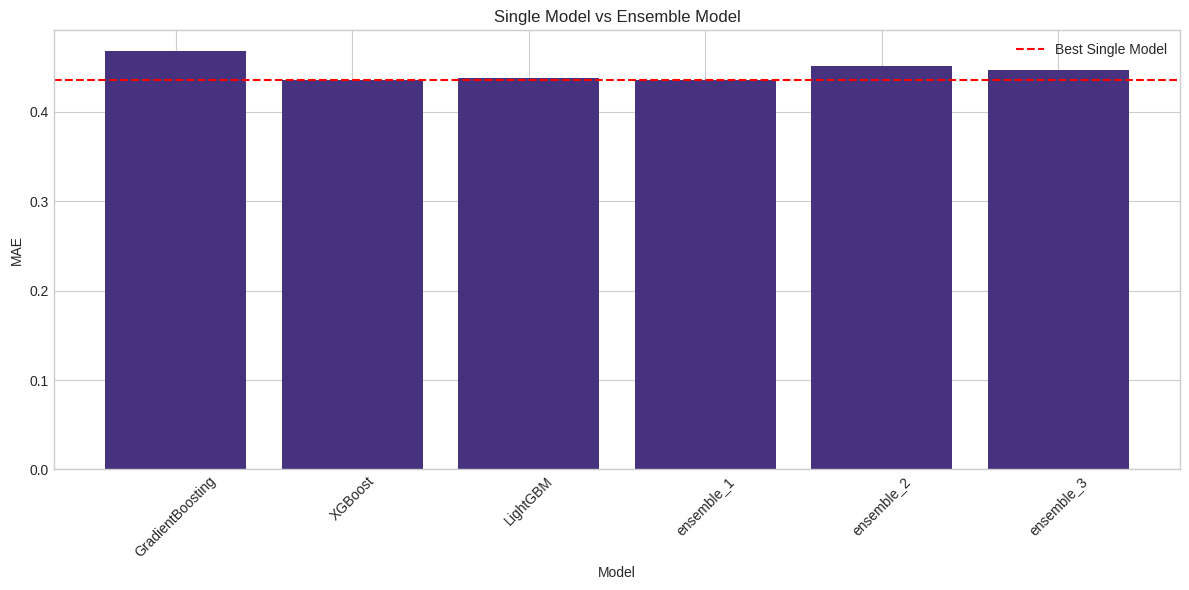

In [86]:
# 여러 모델의 예측을 가중 평균하는 앙상블
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 앙상블할 기본 모델들
base_models = {
    'GradientBoosting': GradientBoostingRegressor(n_estimators=30, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=30, learning_rate=0.1, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=30, learning_rate=0.1, random_state=42)
}

# 모델 학습 및 예측값 저장
base_preds = {}
base_scores = {}

for name, model in base_models.items():
    print(f"{name} 모델 학습 중...")
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    base_preds[name] = pred
    mae = mean_absolute_error(y_val, pred)
    base_scores[name] = mae
    print(f"{name} 모델 MAE: {mae:.4f}")

# 다양한 가중치 조합 실험
weight_combinations = [
    {'XGBoost': 0.5, 'LightGBM': 0.5},
    {'GradientBoosting': 0.5, 'LightGBM': 0.5},
    {'GradientBoosting': 0.4, 'XGBoost': 0.3, 'LightGBM': 0.3},
]

ensemble_results = {}

for i, weights in enumerate(weight_combinations):
    ensemble_pred = np.zeros_like(list(base_preds.values())[0])
    for name, weight in weights.items():
        ensemble_pred += base_preds[name] * weight

    mae = mean_absolute_error(y_val, ensemble_pred)
    ensemble_results[f'ensemble_{i+1}'] = mae
    print(f"앙상블_{i+1} MAE: {mae:.4f} | 조합: {weights}")

# 결과 시각화
plt.figure(figsize=(12, 6))
all_results = {**base_scores, **ensemble_results}
plt.bar(all_results.keys(), all_results.values())
plt.axhline(y=min(base_scores.values()), color='r', linestyle='--', label='Best Single Model')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Single Model vs Ensemble Model')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

 #### 2.2 스태킹 앙상블(Stacking Ensemble) 구현


In [87]:
# 전체에서 5,000개 샘플만 랜덤 추출 (재현 가능성 위해 random_state 지정)
from sklearn.model_selection import train_test_split

X_small, _, y_small, _ = train_test_split(
    X_train, y_train,
    train_size=5000,
    random_state=42,
    stratify=None  # 위험군 등 균형 유지하려면 stratify 사용 가능
)

print(f"📦 소형 샘플 생성 완료: X_small={X_small.shape}, y_small={y_small.shape}")

📦 소형 샘플 생성 완료: X_small=(5000, 197), y_small=(5000,)


In [88]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# 1단계 기본 모델 정의
base_models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
}

# 메타 모델 정의
meta_model = Ridge(alpha=1.0)

# K-Fold 설정
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# OOF 함수 정의
def get_oof_predictions(models, X, y, X_test):
    oof_preds = np.zeros((X.shape[0], len(models)))
    test_preds = np.zeros((X_test.shape[0], len(models)))

    for i, (name, model) in enumerate(models.items()):
        test_fold_preds = np.zeros((X_test.shape[0], kf.n_splits))

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]

            model.fit(X_train_fold, y_train_fold)
            oof_preds[val_idx, i] = model.predict(X_val_fold)
            test_fold_preds[:, fold] = model.predict(X_test)

        test_preds[:, i] = test_fold_preds.mean(axis=1)
        model.fit(X, y)

    return oof_preds, test_preds

# ▶️ 실험용 소형 데이터셋 사용
X_tr, X_val, y_tr, y_val = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

# 스태킹 훈련
oof_tr_preds, val_meta_features = get_oof_predictions(base_models, X_tr, y_tr, X_val)
meta_model.fit(oof_tr_preds, y_tr)
stacking_preds = meta_model.predict(val_meta_features)
stacking_mae = mean_absolute_error(y_val, stacking_preds)

print(f"✅ 소형 스태킹 앙상블 실험 MAE: {stacking_mae:.4f}")

✅ 소형 스태킹 앙상블 실험 MAE: 0.4382


### 3. 특성 선택 및 중요도 분석
#### 3.1 순차적 특성 선택 구현

In [89]:
# 특성 중요도 기반 순차적 특성 선택
from sklearn.feature_selection import SequentialFeatureSelector


# 기본 모델
gb_model_fast = GradientBoostingRegressor(n_estimators=10, max_depth=3, random_state=42)

# Forward Sequential Feature Selection
# 빠른 SFS 설정
sfs = SequentialFeatureSelector(
    gb_model_fast,
    n_features_to_select=10,  # 20 → 10개로 실험
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=2,                     # 5 → 2로 줄이기
    n_jobs=-1
)


# 특성 선택 수행 (시간이 오래 걸릴 수 있음)
print("순차적 특성 선택 수행 중...")
sfs.fit(X_small, y_small)

# 선택된 특성
selected_features = X_small.columns[sfs.get_support()]
print(f"선택된 특성 수: {len(selected_features)}")
print("선택된 특성:")
print(selected_features.tolist())

# 선택된 특성만으로 모델 학습
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

sfs_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
sfs_model.fit(X_train_selected, y_train)
sfs_pred = sfs_model.predict(X_val_selected)
sfs_mae = mean_absolute_error(y_val, sfs_pred)

# 전체 특성 기준 MAE (비교용)
full_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
full_model.fit(X_train, y_train)
base_mae = mean_absolute_error(y_val, full_model.predict(X_val))



print(f"선택된 특성만 사용한 모델 MAE: {sfs_mae:.4f}")
print(f"모든 특성 사용 MAE와의 차이: {(sfs_mae - base_mae) / base_mae * 100:.2f}%")


순차적 특성 선택 수행 중...
선택된 특성 수: 10
선택된 특성:
['cat12_A', 'cat53_encoded', 'cat57_encoded', 'cat79_encoded', 'cat80_encoded', 'cat81_encoded', 'cat94_encoded', 'cat100_encoded', 'cat101_encoded', 'cat103_encoded']
선택된 특성만 사용한 모델 MAE: 0.4688
모든 특성 사용 MAE와의 차이: 8.94%


#### 3.2 특성 중요도의 통계적 안정성 분석

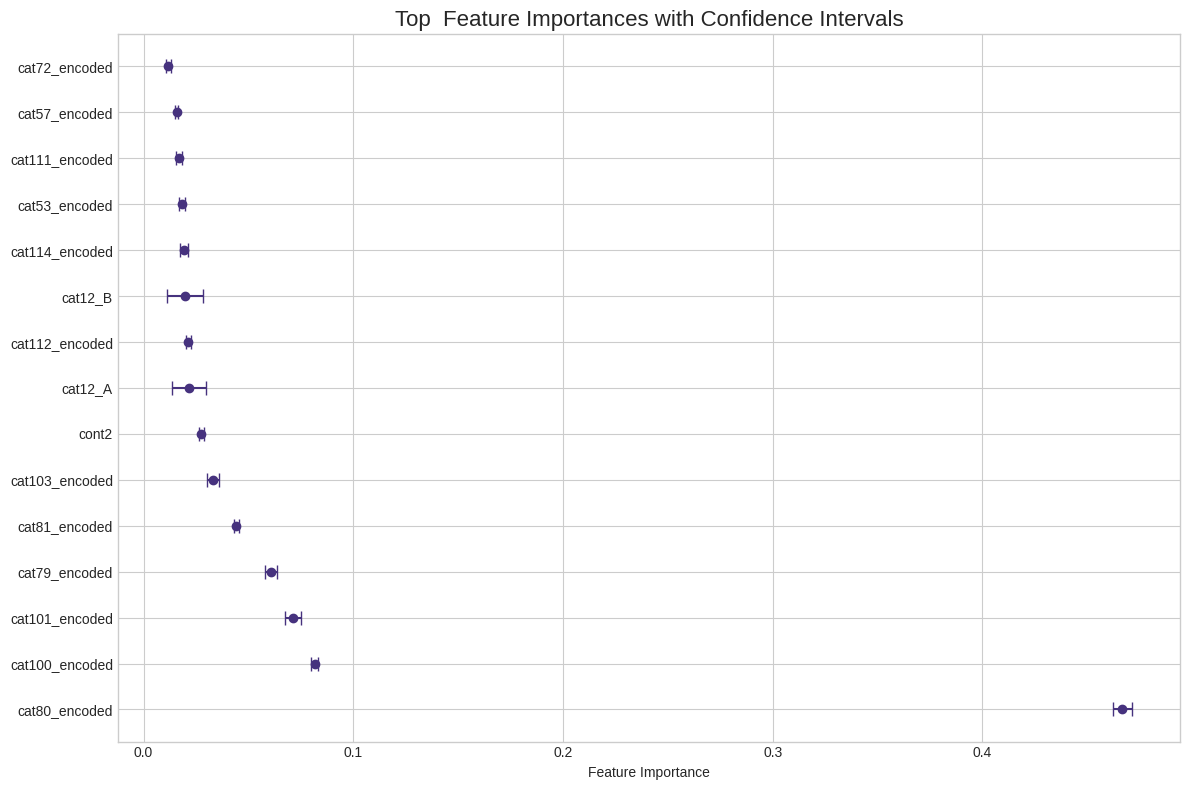

가장 안정적인 특성 (낮은 변동계수):
            feature  mean_importance  coef_variation
143   cat80_encoded         0.466711        0.009709
163  cat100_encoded         0.081585        0.020282
144   cat81_encoded         0.044175        0.028408
1             cont2         0.027553        0.038204
120   cat57_encoded         0.015810        0.045221
142   cat79_encoded         0.060769        0.048434
175  cat112_encoded         0.021309        0.051905
164  cat101_encoded         0.071353        0.054185
116   cat53_encoded         0.018439        0.084476
166  cat103_encoded         0.033045        0.086717
174  cat111_encoded         0.016775        0.090988
135   cat72_encoded         0.011883        0.093013
171  cat108_encoded         0.010359        0.103634
177  cat114_encoded         0.019388        0.105788
6             cont7         0.009061        0.156124
179  cat116_encoded         0.005688        0.228524
181     gmm_cluster         0.010077        0.258234
157   cat94_encoded     

In [90]:
# Bootstrap 샘플링을 통한 특성 중요도의 안정성 분석
from sklearn.utils import resample

# 모델 정의
model = GradientBoostingRegressor(n_estimators=30, random_state=42)

# Bootstrap 반복 횟수
n_iterations = 15
n_features = X_train.shape[1]

# 결과 저장용 배열
all_importances = np.zeros((n_iterations, n_features))

# Bootstrap 샘플링 및 특성 중요도 계산
for i in range(n_iterations):
    # Bootstrap 샘플 생성
    X_boot, y_boot = resample(X_train, y_train, random_state=i)

    # 모델 학습
    model.fit(X_boot, y_boot)

    # 특성 중요도 저장
    all_importances[i, :] = model.feature_importances_

# 특성별 중요도 평균과 표준편차
mean_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# 결과 데이터프레임 생성
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'mean_importance': mean_importance,
    'std_importance': std_importance,
    'coef_variation': std_importance / mean_importance  # 변동계수
})

# 중요도 기준으로 정렬
feature_importance_df = feature_importance_df.sort_values('mean_importance', ascending=False)

# 상위 15개 특성 시각화
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)

# 특성 중요도와 신뢰구간 시각화
plt.errorbar(
    top_features['mean_importance'],
    top_features['feature'],
    xerr=top_features['std_importance'],
    fmt='o',
    capsize=5
)

plt.title('Top  Feature Importances with Confidence Intervals', fontsize=16)
plt.xlabel('Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

# 변동계수가 낮은(안정적인) 특성들
stable_features = feature_importance_df.sort_values('coef_variation').head(20)
print("가장 안정적인 특성 (낮은 변동계수):")
print(stable_features[['feature', 'mean_importance', 'coef_variation']])


### 4. 도메인 특화 모델링 접근법
#### 4.1 커스텀 손실 함수 구현

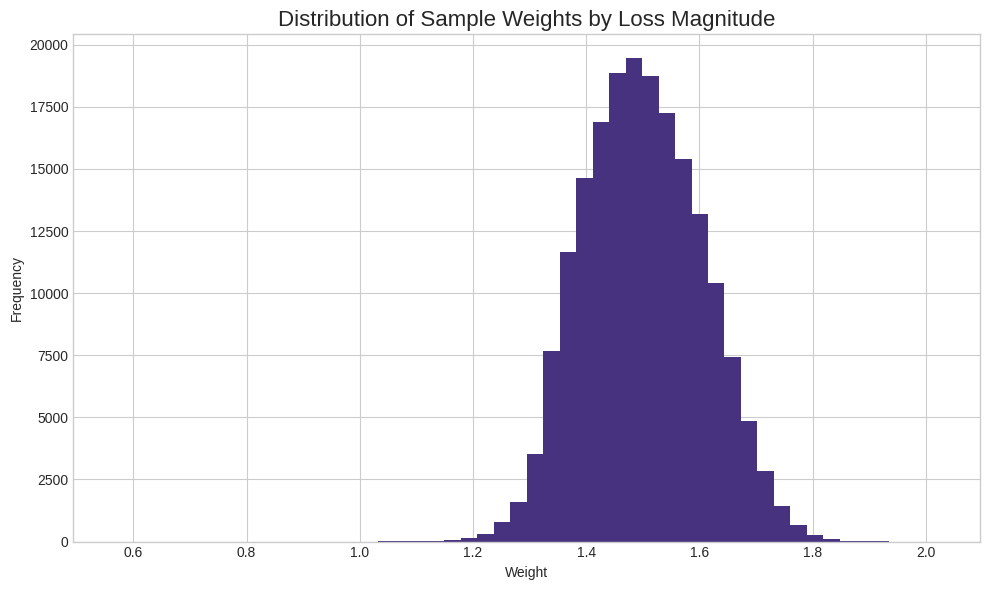

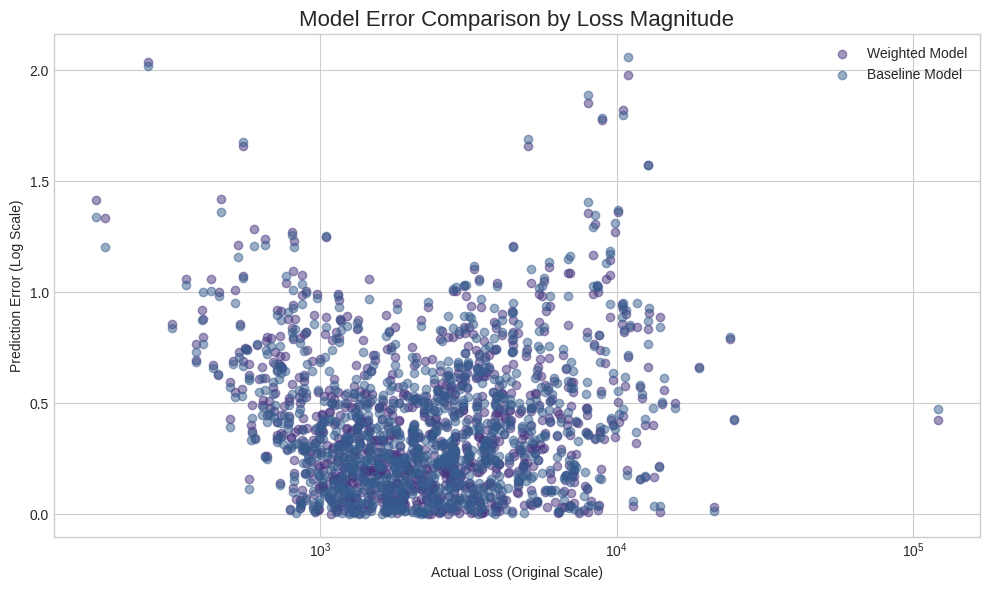

가중치 적용 모델 MAE: 0.4037
기본 모델 MAE: 0.4042
MAE 차이: -0.14%

대형 손실(상위 10%)에 대한 성능:
가중치 적용 모델 MAE: 0.5830
기본 모델 MAE: 0.6045
개선율: 3.56%


In [91]:
# 보험 도메인에 특화된 커스텀 손실 함수 구현
# 큰 손실에 더 큰 페널티를 부여하는 가중 MAE
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 손실 크기에 따른 가중치 함수
def calculate_weights(y):
    # 예측 손실이 클수록 더 큰 가중치 부여
    # 로그스케일 가정
    y_exp = np.exp(y) - 1  # 원래 스케일로 변환
    weights = np.log1p(y_exp) / np.mean(np.log1p(y_exp))  # 정규화된 가중치
    return weights + 0.5  # 기본 가중치 추가

# 학습 데이터의 가중치 계산
sample_weights = calculate_weights(y_train.values)

# 가중치 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(sample_weights, bins=50)
plt.title('Distribution of Sample Weights by Loss Magnitude', fontsize=16)
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost의 경우 sample_weight 매개변수로 가중치 전달
weighted_xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 가중치를 적용한 모델 학습
weighted_xgb.fit(X_train, y_train, sample_weight=sample_weights)

# 가중치 없는 기본 모델
regular_xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
regular_xgb.fit(X_train, y_train)

# 검증 세트에서 성능 비교
weighted_pred = weighted_xgb.predict(X_val)
regular_pred = regular_xgb.predict(X_val)

weighted_mae = mean_absolute_error(y_val, weighted_pred)
regular_mae = mean_absolute_error(y_val, regular_pred)

# 손실 크기별 오차 분석
val_loss_exp = np.exp(y_val) - 1  # 원래 스케일로 변환
weighted_error = np.abs(y_val - weighted_pred)
regular_error = np.abs(y_val - regular_pred)

# 손실 크기에 따른 오차 비교
plt.figure(figsize=(10, 6))
plt.scatter(val_loss_exp, weighted_error, alpha=0.5, label='Weighted Model')
plt.scatter(val_loss_exp, regular_error, alpha=0.5, label='Baseline Model')
plt.xscale('log')
plt.xlabel('Actual Loss (Original Scale)')
plt.ylabel('Prediction Error (Log Scale)')
plt.title('Model Error Comparison by Loss Magnitude', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"가중치 적용 모델 MAE: {weighted_mae:.4f}")
print(f"기본 모델 MAE: {regular_mae:.4f}")
print(f"MAE 차이: {(weighted_mae - regular_mae) / regular_mae * 100:.2f}%")

# 대형 손실(상위 10%)에 대한 성능 비교
large_loss_threshold = np.percentile(y_val, 90)
large_loss_mask = y_val > large_loss_threshold

large_loss_weighted_mae = mean_absolute_error(
    y_val[large_loss_mask],
    weighted_pred[large_loss_mask]
)
large_loss_regular_mae = mean_absolute_error(
    y_val[large_loss_mask],
    regular_pred[large_loss_mask]
)

print(f"\n대형 손실(상위 10%)에 대한 성능:")
print(f"가중치 적용 모델 MAE: {large_loss_weighted_mae:.4f}")
print(f"기본 모델 MAE: {large_loss_regular_mae:.4f}")
print(f"개선율: {(large_loss_regular_mae - large_loss_weighted_mae) / large_loss_regular_mae * 100:.2f}%")


### 4.2 고객 특성별 세분화 모델

In [92]:
# 기본 모델로 중요도 계산
from lightgbm import LGBMRegressor

temp_model = LGBMRegressor(n_estimators=30, random_state=42)
temp_model.fit(X_train, y_train)

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': temp_model.feature_importances_
}).sort_values(by='importance', ascending=False)

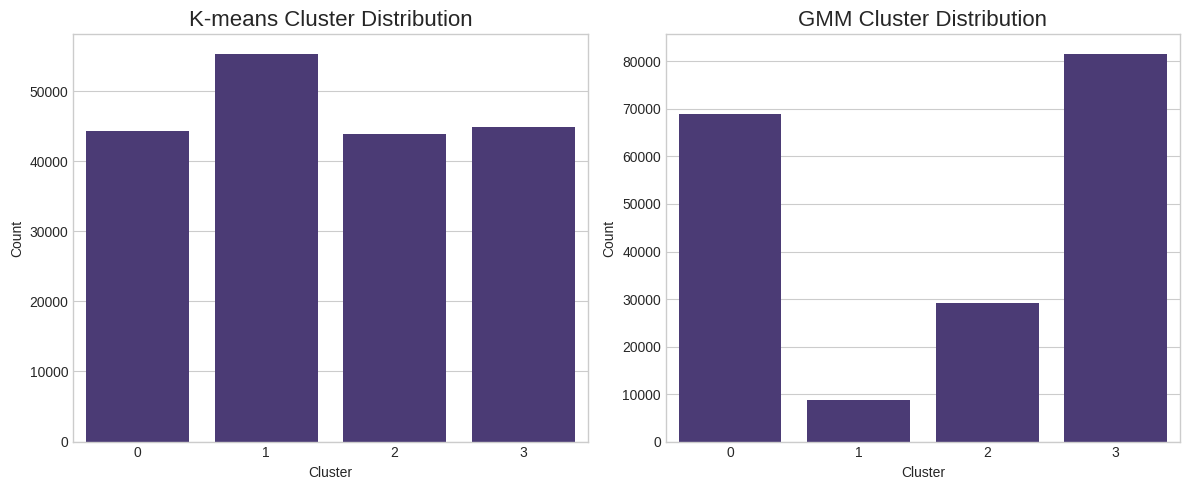

In [93]:
# 고객 특성별 세분화 모델 구현
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# 클러스터링을 위한 특성 선택
# 중요 특성 50개 선택
top_features = feature_importance_df['feature'].head(50).tolist()
cluster_data = X_train[top_features].copy()

# K-means 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
X_train['kmeans_cluster'] = kmeans.fit_predict(cluster_data)
X_val['kmeans_cluster'] = kmeans.predict(X_val[top_features])

# GMM 클러스터링
gmm = GaussianMixture(n_components=4, random_state=42)
X_train['gmm_cluster'] = gmm.fit_predict(cluster_data)
X_val['gmm_cluster'] = gmm.predict(X_val[top_features])

# 클러스터 분포 시각화
plt.figure(figsize=(12, 5))

# K-means cluster distribution
plt.subplot(1, 2, 1)
sns.countplot(x='kmeans_cluster', data=X_train)
plt.title('K-means Cluster Distribution', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Count')

# GMM cluster distribution
plt.subplot(1, 2, 2)
sns.countplot(x='gmm_cluster', data=X_train)
plt.title('GMM Cluster Distribution', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.tight_layout()
plt.show()



### 5. 최종 모델 학습 및 예측

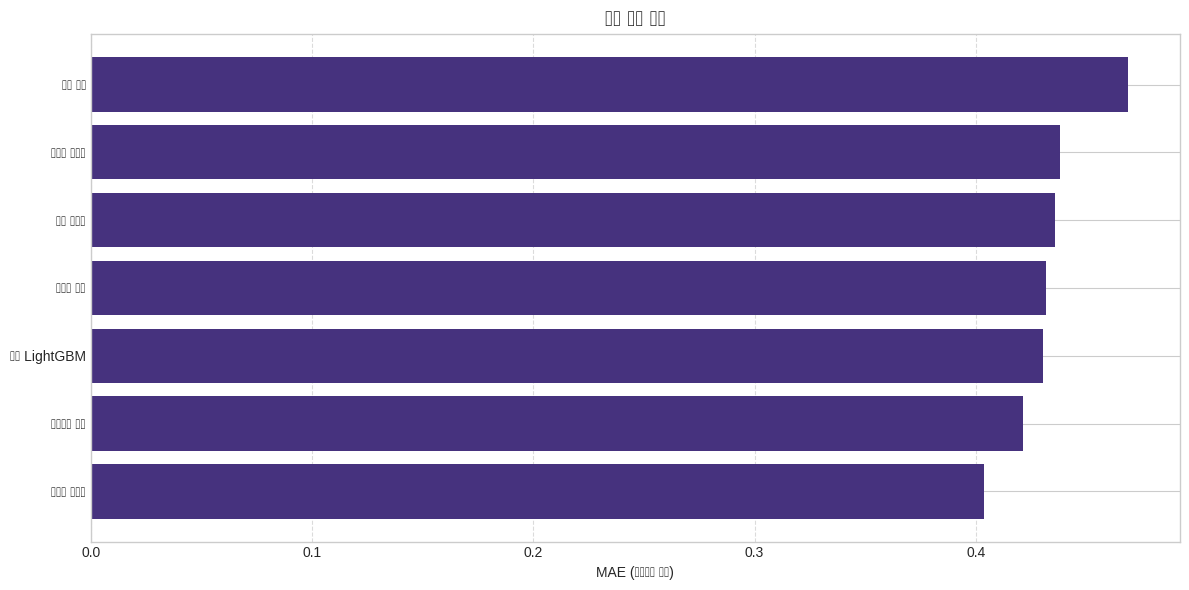

📊 최고 성능 모델: 가중치 샘플링, MAE: 0.4037


In [94]:
# 모든 실험 모델의 성능 비교
model_performance = {
    '기본 LightGBM': base_mae,
    '상호작용 특성': interaction_mae,
    '다항식 특성': poly_mae,
    '가중 앙상블': min(ensemble_results.values()),
    '스태킹 앙상블': stacking_mae,
    '특성 선택': sfs_mae,
    '가중치 샘플링': weighted_mae
}

# 성능 비교 시각화
plt.figure(figsize=(12, 6))
models = list(model_performance.keys())
scores = list(model_performance.values())

# 내림차순 정렬
sorted_idx = np.argsort(scores)
plt.barh([models[i] for i in sorted_idx], [scores[i] for i in sorted_idx])
plt.xlabel('MAE (낮을수록 좋음)')
plt.title('모델 성능 비교', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 최고 성능 모델 확인
best_model_name = models[np.argmin(scores)]
best_score = min(scores)
print(f"📊 최고 성능 모델: {best_model_name}, MAE: {best_score:.4f}")


# 보험료

## 1.보험료 산출 및 분석

In [46]:
# 보험료 계산 (기본 산출 방식)
base_loading = 0.2  # 기본 로딩률
base_margin = 0.1   # 기본 마진
base_premium = test_pred_loss * (1 + base_loading + base_margin)

In [47]:
# 리스크 특성별 로딩률 차등화 - 새로운 접근법
# 예측된 손해액 크기에 따라 로딩률 차등 적용
loss_quantiles = np.percentile(test_pred_loss, [25, 50, 75, 90])

def get_risk_loading(loss):
    if loss < loss_quantiles[0]:
        return 0.15  # 낮은 손해 예상 -> 낮은 로딩률
    elif loss < loss_quantiles[1]:
        return 0.18
    elif loss < loss_quantiles[2]:
        return 0.22
    elif loss < loss_quantiles[3]:
        return 0.25
    else:
        return 0.30  # 높은 손해 예상 -> 높은 로딩률


In [48]:
# 로딩률 차등 적용
dynamic_loading = np.array([get_risk_loading(loss) for loss in test_pred_loss])
dynamic_premium = test_pred_loss * (1 + dynamic_loading + base_margin)


In [49]:
# 보험료 산출 결과 비교
premium_comparison = pd.DataFrame({
    'id': test_df['id'],
    'predicted_loss': test_pred_loss,
    'base_premium': base_premium,
    'dynamic_premium': dynamic_premium,
    'loading_rate': dynamic_loading
})

# 일부 확인
premium_comparison.head()

,id,predicted_loss,base_premium,dynamic_premium,loading_rate
0,4,2029.263028,2638.041937,2597.456676,0.18
1,6,2336.751413,3037.776836,2991.041808,0.18
2,9,10178.788248,13232.424723,14250.303548,0.30
3,12,7170.072975,9321.094867,10038.102165,0.30
4,15,889.922381,1156.899095,1112.402976,0.15


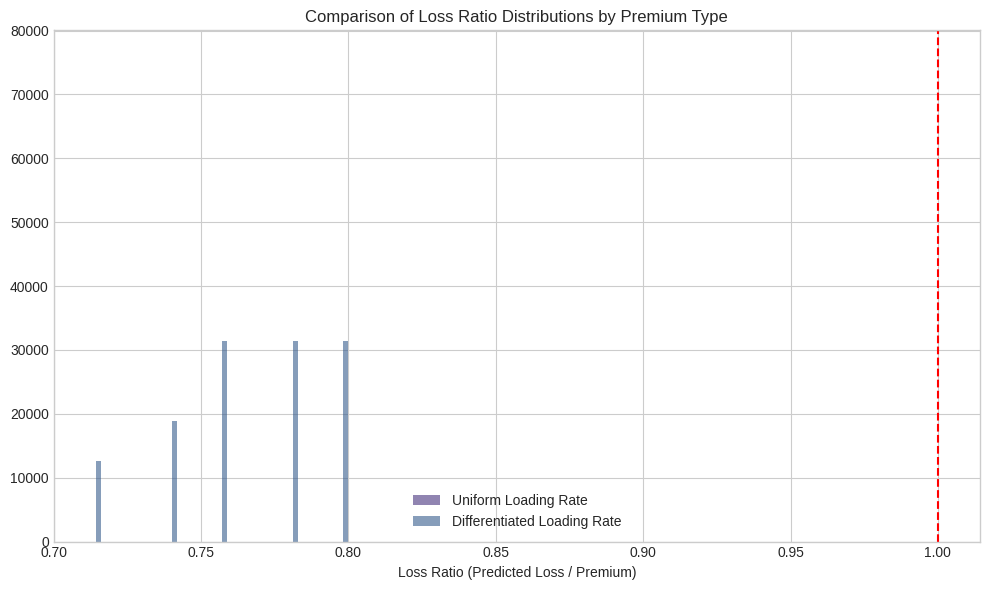

In [50]:
# 손해율 계산 (예측 손해액 / 보험료)
premium_comparison['base_claim_ratio'] = premium_comparison['predicted_loss'] / premium_comparison['base_premium']
premium_comparison['dynamic_claim_ratio'] = premium_comparison['predicted_loss'] / premium_comparison['dynamic_premium']

# 손해율 분포 비교
plt.figure(figsize=(10,6))
plt.hist(premium_comparison['base_claim_ratio'], bins=50, alpha=0.6, label='Uniform Loading Rate')
plt.hist(premium_comparison['dynamic_claim_ratio'], bins=50, alpha=0.6, label='Differentiated Loading Rate')
plt.axvline(x=1.0, color='red', linestyle='--')
plt.title('Comparison of Loss Ratio Distributions by Premium Type')
plt.xlabel('Loss Ratio (Predicted Loss / Premium)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. 고객 리스크 세그먼트 분석


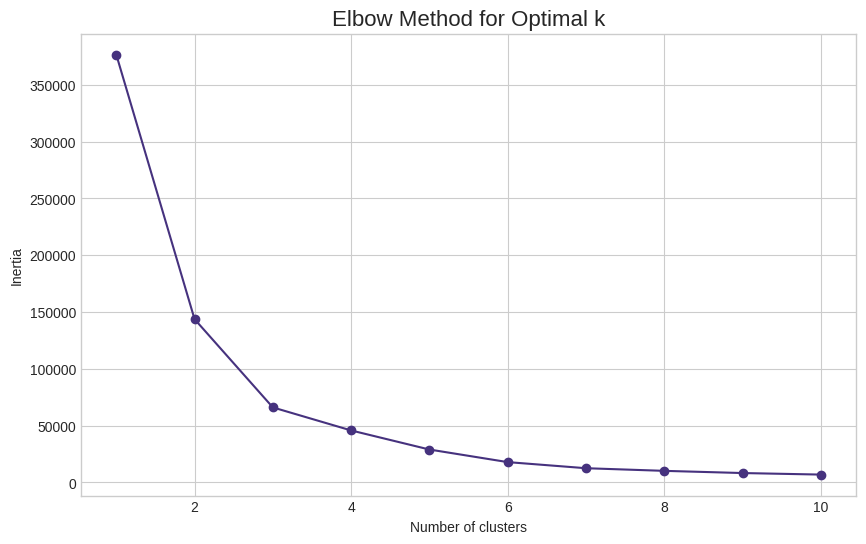

In [52]:
# 고객 리스크 클러스터링
from sklearn.cluster import KMeans

# 클러스터링을 위한 특성 선택
cluster_features = ['predicted_loss', 'dynamic_premium', 'dynamic_claim_ratio']
cluster_data = premium_comparison[cluster_features].copy()

# 변수 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# 최적 클러스터 수 결정 (엘보우 방식)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [53]:
# 클러스터링 적용 (최적 k 선택 후)
optimal_k = 4  # 엘보우 곡선에서 식별된 최적값
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
premium_comparison['risk_segment'] = kmeans.fit_predict(scaled_data)

# 클러스터별 통계 분석
segment_stats = premium_comparison.groupby('risk_segment').agg({
    'predicted_loss': ['mean', 'min', 'max', 'count'],
    'dynamic_premium': ['mean', 'min', 'max'],
    'dynamic_claim_ratio': ['mean', 'min', 'max']
})

print("Statics of Risk Segment:")
print(segment_stats)

Statics of Risk Segment:
             predicted_loss                                   dynamic_premium  \
                       mean          min           max  count            mean   
risk_segment                                                                    
0               1836.369776   532.413894   2640.755765  62773     2328.861204   
1               6522.920357  5108.374754   8921.756314  15868     9003.994721   
2              11491.635588  8922.293990  63782.102705   3942    16088.289823   
3               3591.405546  2640.773325   5108.183102  42963     4777.213471   

                                         dynamic_claim_ratio            \
                       min           max                mean       min   
risk_segment                                                             
0               665.517368   3380.167379            0.790625  0.781250   
1              6896.305918  12490.458840            0.726381  0.714286   
2             12491.211585  89294.943

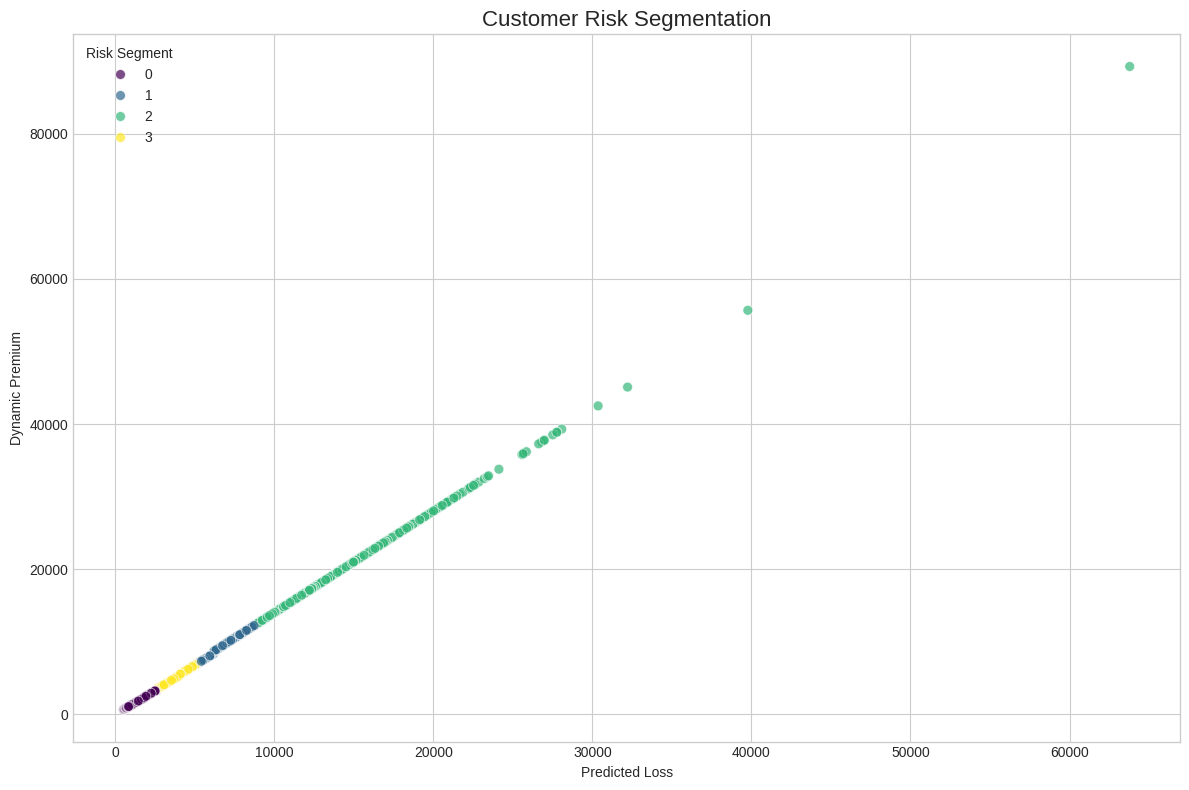

In [54]:
# 클러스터 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=premium_comparison,
    x='predicted_loss',
    y='dynamic_premium',
    hue='risk_segment',
    palette='viridis',
    alpha=0.7,
    s=50
)
plt.title('Customer Risk Segmentation', fontsize=16)
plt.xlabel('Predicted Loss')
plt.ylabel('Dynamic Premium')
plt.grid(True)
plt.legend(title='Risk Segment')
plt.tight_layout()
plt.show()

## 3. 보험료 최적화 모델

In [55]:
# 최적 보험료 산출 모델 개발
# - 리스크 세그먼트별 특성에 기반한 요율 모델

# 요율 계수 계산 (예측 손해액 대비 보험료 비율)
premium_comparison['rate_factor'] = premium_comparison['dynamic_premium'] / premium_comparison['predicted_loss']

# 요율 모델 학습을 위한 데이터 준비
X_rate = X_test.copy()  # 모든 예측 모델 입력 특성 재사용
y_rate = premium_comparison['rate_factor']  # 목표: 요율 계수 예측

# 요율 모델 학습
from sklearn.ensemble import GradientBoostingRegressor
rate_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=20,
    random_state=42
)

rate_model.fit(X_rate, y_rate)

# 요율 예측 및 최적 보험료 계산
predicted_rate = rate_model.predict(X_rate)
premium_comparison['optimized_premium'] = premium_comparison['predicted_loss'] * predicted_rate
premium_comparison['optimized_claim_ratio'] = premium_comparison['predicted_loss'] / premium_comparison['optimized_premium']


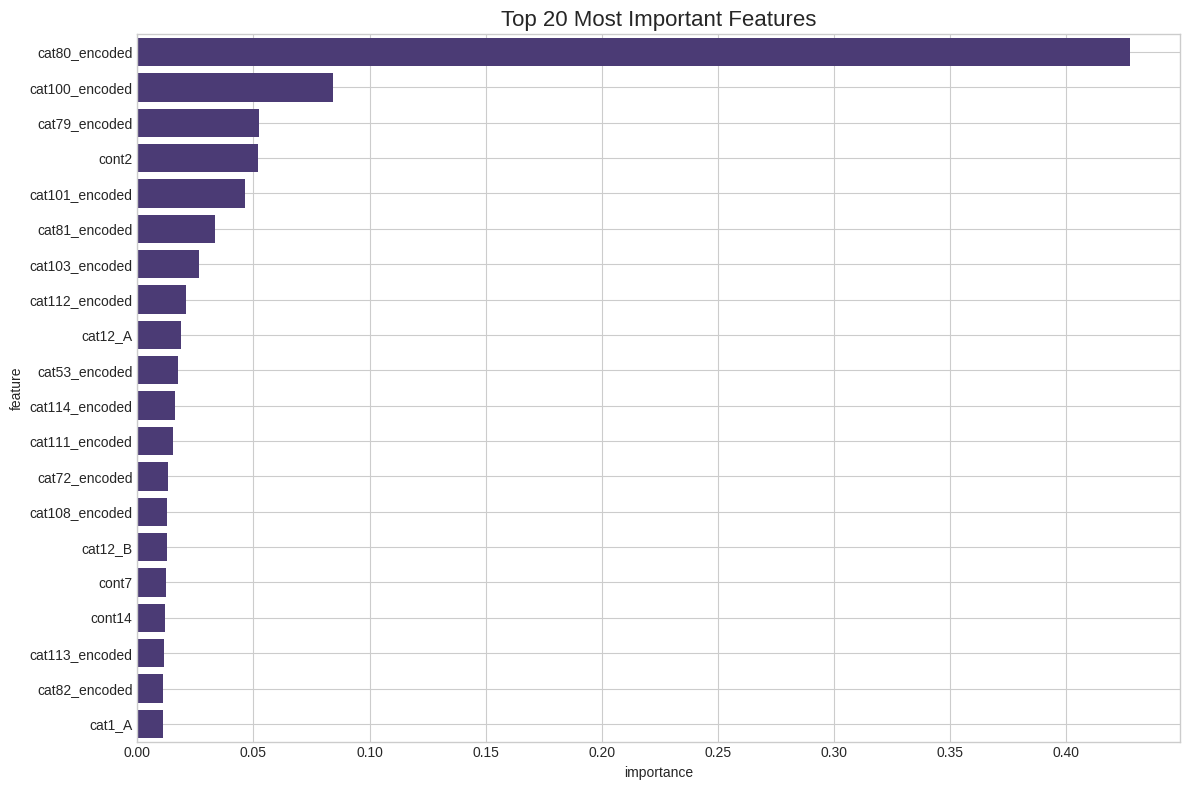

In [56]:
# 요율 모델의 특성 중요도 분석
rate_importances = rate_model.feature_importances_
rate_features = X_rate.columns

rate_imp_df = pd.DataFrame({'feature': rate_features, 'importance': rate_importances})
rate_imp_df = rate_imp_df.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=rate_imp_df)
plt.title('Top 20 Most Important Features', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

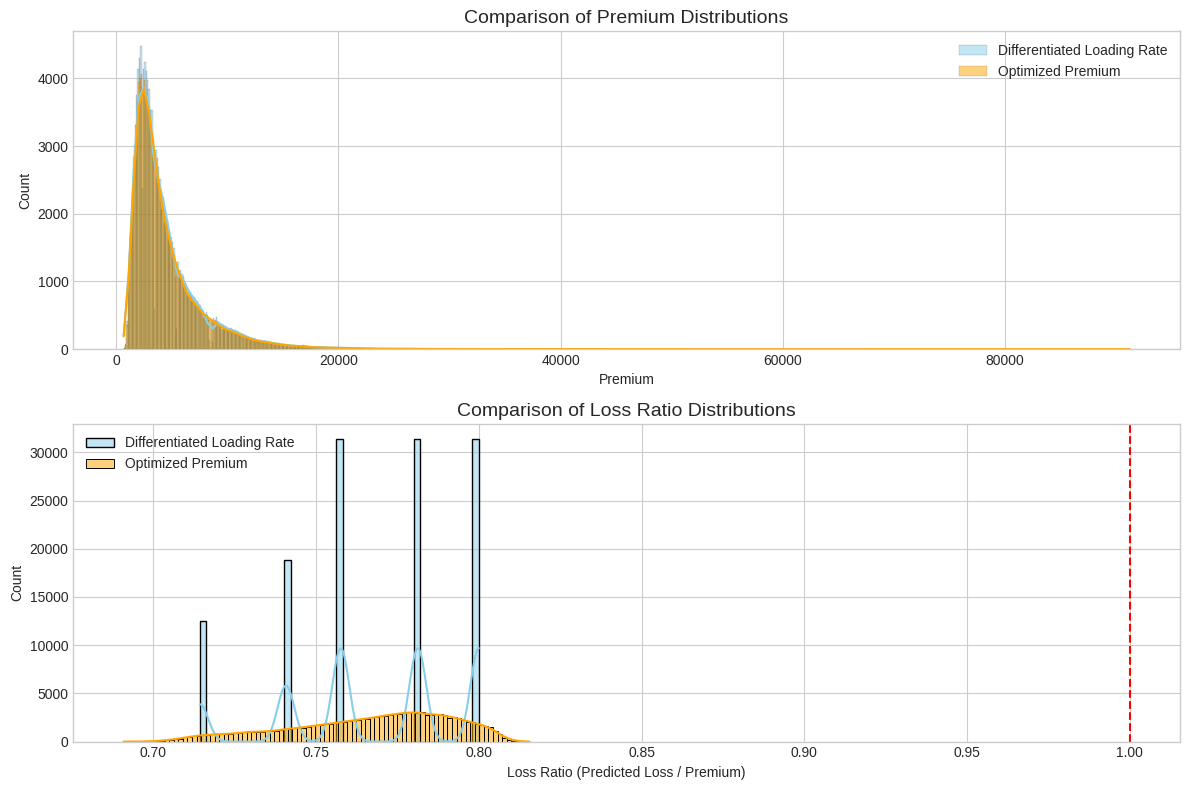

In [57]:
# 최적화된 보험료 분포 시각화
plt.figure(figsize=(12, 8))

# 1번 그래프: 보험료 분포 비교 → Premium distribution comparison
plt.subplot(2, 1, 1)
sns.histplot(premium_comparison['dynamic_premium'], color='skyblue', kde=True, label='Differentiated Loading Rate')
sns.histplot(premium_comparison['optimized_premium'], color='orange', kde=True, label='Optimized Premium')
plt.title('Comparison of Premium Distributions', fontsize=14)
plt.xlabel('Premium')
plt.legend()

# 2번 그래프: 손해율 분포 비교 → Loss ratio distribution comparison
plt.subplot(2, 1, 2)
sns.histplot(premium_comparison['dynamic_claim_ratio'], color='skyblue', kde=True, label='Differentiated Loading Rate')
sns.histplot(premium_comparison['optimized_claim_ratio'], color='orange', kde=True, label='Optimized Premium')
plt.axvline(x=1.0, color='red', linestyle='--')
plt.title('Comparison of Loss Ratio Distributions', fontsize=14)
plt.xlabel('Loss Ratio (Predicted Loss / Premium)')
plt.legend()

plt.tight_layout()
plt.show()

## 4. 보험료 조정 시뮬레이션

In [58]:
# 보험료 인상/인하 시나리오 시뮬레이션
scenarios = {
    'Base': premium_comparison['optimized_premium'],
    '5% Increase': premium_comparison['optimized_premium'] * 1.05,
    '10% Increase': premium_comparison['optimized_premium'] * 1.10,
    '5% Decrease': premium_comparison['optimized_premium'] * 0.95
}

# 시나리오별 손해율 계산
scenario_results = {}
for name, premium in scenarios.items():
    claim_ratio = premium_comparison['predicted_loss'] / premium
    avg_ratio = claim_ratio.mean()
    profitable_pct = (claim_ratio < 1.0).mean() * 100

    scenario_results[name] = {
        'Average Loss Ratio': avg_ratio,
        'Profitable Customers (%)': profitable_pct,
        'Total Premium': premium.sum(),
        'Premium Change (%)': (premium.sum() / scenarios['Base'].sum() - 1) * 100
    }

# 결과를 데이터프레임으로 변환
scenario_df = pd.DataFrame(scenario_results).T
print("\nAnalysis of Premium Adjustment Scenarios:")
print(scenario_df)


Analysis of Premium Adjustment Scenarios:
              Average Loss Ratio  Profitable Customers (%)  Total Premium  \
Base                    0.767071                     100.0   5.568875e+08   
5% Increase             0.730544                     100.0   5.847319e+08   
10% Increase            0.697337                     100.0   6.125763e+08   
5% Decrease             0.807443                     100.0   5.290431e+08   

              Premium Change (%)  
Base                         0.0  
5% Increase                  5.0  
10% Increase                10.0  
5% Decrease                 -5.0  


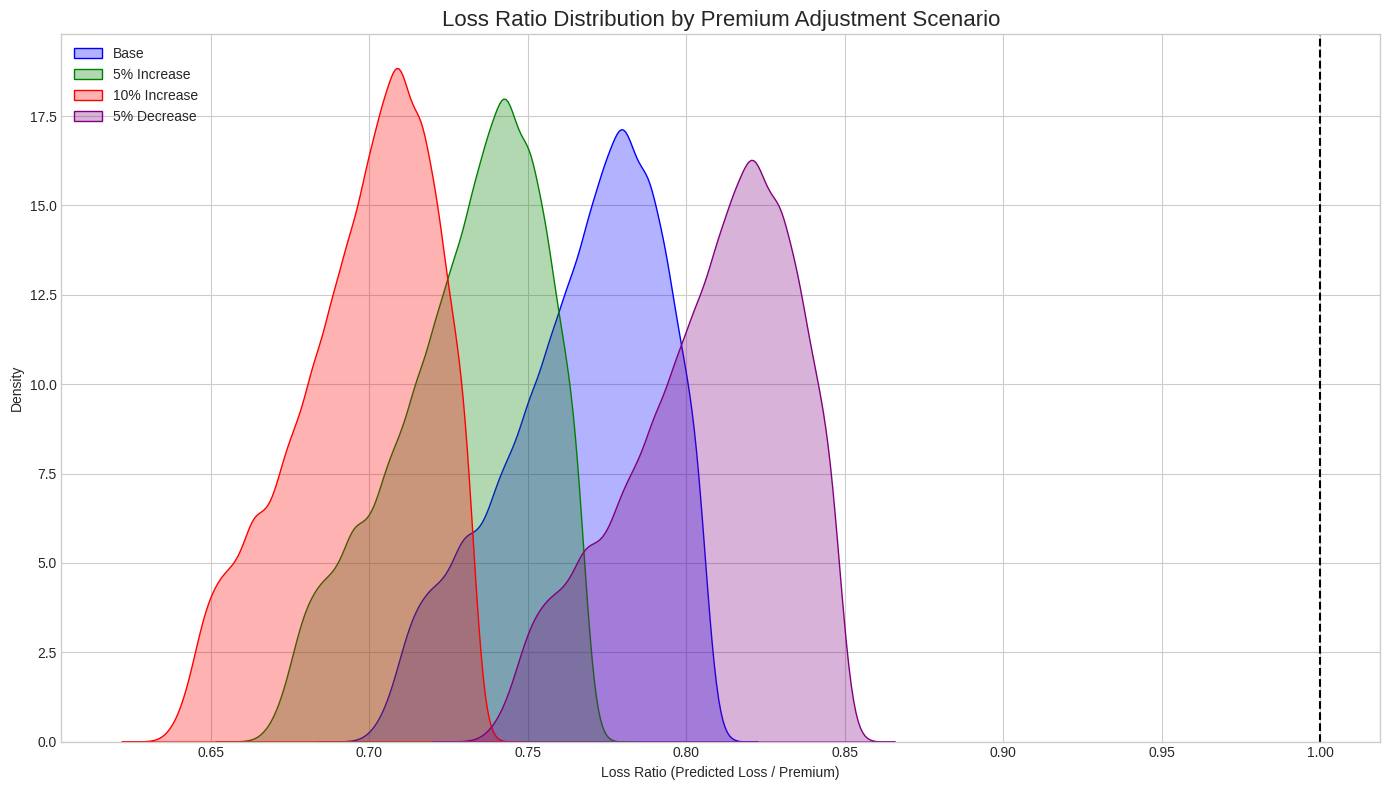

In [59]:
# 시나리오별 손해율 분포 시각화
plt.figure(figsize=(14, 8))
colors = ['blue', 'green', 'red', 'purple']

for i, (name, premium) in enumerate(scenarios.items()):
    claim_ratio = premium_comparison['predicted_loss'] / premium
    sns.kdeplot(claim_ratio, label=name, color=colors[i], fill=True, alpha=0.3)

plt.axvline(x=1.0, color='black', linestyle='--')
plt.title('Loss Ratio Distribution by Premium Adjustment Scenario', fontsize=16)
plt.xlabel('Loss Ratio (Predicted Loss / Premium)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. 손익기반 수익성 분석

In [60]:
# 기본 데이터
premium = premium_comparison['optimized_premium']
loss = premium_comparison['predicted_loss']
claim_ratio = loss / premium

# 수익성 지표 계산
total_premium = premium.sum()
total_loss = loss.sum()
total_profit = total_premium - total_loss
overall_claim_ratio = total_loss / total_premium
loss_ratio_over_1_pct = (claim_ratio > 1.0).mean() * 100

# 손해율 상위 10% 고객의 손해액 비중
top_10_loss_share = (
    loss[claim_ratio >= claim_ratio.quantile(0.9)].sum() / total_loss
) * 100

# 결과 출력
profit_summary = {
    'Total Premium Revenue': total_premium,
    'Total Predicted Loss': total_loss,
    'Total Profit': total_profit,
    'Overall Loss Ratio': overall_claim_ratio,
    'Customers with Loss Ratio > 1.0 (%)': loss_ratio_over_1_pct,
    'Top 10% Loss Ratio Group Share (%)': top_10_loss_share
}

import pandas as pd
profit_df = pd.DataFrame(profit_summary, index=['Result']).T
print("📌 손익 기반 수익성 분석:")
print(profit_df)

📌 손익 기반 수익성 분석:
                                           Result
Total Premium Revenue                5.568875e+08
Total Predicted Loss                 4.183777e+08
Total Profit                         1.385098e+08
Overall Loss Ratio                   7.512787e-01
Customers with Loss Ratio > 1.0 (%)  0.000000e+00
Top 10% Loss Ratio Group Share (%)   3.618264e+00


## 6. 사업적 제약 반영 보험료 시뮬레이션

In [61]:
# 기본 입력
loss = premium_comparison['predicted_loss']
base_premium = premium_comparison['base_premium']

# 1. 로딩률 산출 (예: 위험 기반 로딩)
raw_loading_rate = 0.1 + 0.00001 * loss  # 예시: 손해액에 비례
# 2. 제약조건 적용
capped_loading_rate = raw_loading_rate.clip(upper=0.30)  # 최대 30%

# 3. 보험료 재계산 (base_premium × (1 + 로딩률))
constrained_premium = base_premium * (1 + capped_loading_rate)

# 4. 최소 보험료 설정 (예: 1000원)
final_premium = constrained_premium.clip(lower=1000)

# 5. 손해율 계산
claim_ratio = loss / final_premium
profitability_pct = (claim_ratio < 1.0).mean() * 100
avg_claim_ratio = claim_ratio.mean()

# 6. 결과 요약
constrained_summary = {
    'Average Premium': final_premium.mean(),
    'Total Premium': final_premium.sum(),
    'Average Loss Ratio': avg_claim_ratio,
    'Profitable Customers (%)': profitability_pct
}

import pandas as pd
constrained_df = pd.DataFrame(constrained_summary, index=['Business Rule Applied']).T
print("📌 사업적 제약 반영 보험료 시뮬레이션 결과:")
print(constrained_df)

# 필요 시 보험료 저장
premium_comparison['constrained_premium'] = final_premium

📌 사업적 제약 반영 보험료 시뮬레이션 결과:
                          Business Rule Applied
Average Premium                    4.976094e+03
Total Premium                      6.247287e+08
Average Loss Ratio                 6.789896e-01
Profitable Customers (%)           1.000000e+02


## 7. 검증 데이터 기반 보험료 실험

In [65]:
# 1. 검증 세트에 대해 손해액 예측 (로그 → 원래 스케일)
val_pred_log = final_model.predict(X_val)                  # 로그 손해 예측
val_pred_loss = np.expm1(val_pred_log)                    # 원래 손해액 복원

# 2. base premium 계산 (예: 손해액 × 1.3)
base_premium_val = val_pred_loss * 1.3

# 3. 손해액에 비례한 최적화 로딩률 적용 (상한선 포함)
loading_rate_val = 0.1 + 0.00001 * val_pred_loss           # 예: 손해 클수록 로딩률 증가
loading_rate_val = np.clip(loading_rate_val, 0.0, 0.3)  # ✅ numpy 방식으로 안전하게 처리

# 4. 최종 보험료 계산
optimized_premium_val = base_premium_val * (1 + loading_rate_val)

# 5. 손해율 계산 (예측 손해액 / 보험료)
claim_ratio_val = y_val / optimized_premium_val
avg_claim_ratio_val = claim_ratio_val.mean()
profitable_pct_val = (claim_ratio_val < 1.0).mean() * 100  # 손해율 100% 미만 비율

# 6. 결과 요약 정리
val_summary = {
    'Average Predicted Loss': val_pred_loss.mean(),
    'Average Optimized Premium': optimized_premium_val.mean(),
    'Average Loss Ratio': avg_claim_ratio_val,
    'Profitable Customers (%)': profitable_pct_val,
    'Total Premium': optimized_premium_val.sum(),
    'Total Predicted Loss': y_val.sum()
}

val_result_df = pd.DataFrame(val_summary, index=['Validation Set']).T

# 결과 출력
print("📌 검증 세트 기반 보험료 실험 결과:")
print(val_result_df)

📌 검증 세트 기반 보험료 실험 결과:
                           Validation Set
Average Predicted Loss       3.345352e+03
Average Optimized Premium    4.998207e+03
Average Loss Ratio           2.095519e-03
Profitable Customers (%)     1.000000e+02
Total Premium                1.882525e+08
Total Predicted Loss         2.895169e+05


In [66]:
# 최종 결과 데이터프레임 구성
final_results = pd.DataFrame({
    'id': test_df['id'],
    'predicted_loss': premium_comparison['predicted_loss'],
    'premium': premium_comparison['optimized_premium'],  # 최적화된 보험료 사용
    'risk_segment': premium_comparison['risk_segment'],
    'claim_ratio': premium_comparison['optimized_claim_ratio']
})

# 결과 요약
print("\n최종 결과 요약:")
print(f"총 고객 수: {len(final_results)}")
print(f"평균 예측 손해액: {final_results['predicted_loss'].mean():.2f}")
print(f"평균 보험료: {final_results['premium'].mean():.2f}")
print(f"평균 손해율: {final_results['claim_ratio'].mean():.4f}")
print(f"손해율 < 1.0인 고객 비율: {(final_results['claim_ratio'] < 1.0).mean() * 100:.2f}%")

# 상위 10개 레코드 확인
final_results.head(10)




최종 결과 요약:
총 고객 수: 125546
평균 예측 손해액: 3332.47
평균 보험료: 4435.72
평균 손해율: 0.7671
손해율 < 1.0인 고객 비율: 100.00%


,id,predicted_loss,premium,risk_segment,claim_ratio
0,4,2029.263028,2605.390709,0,0.778871
1,6,2336.751413,3023.137298,0,0.772956
2,9,10178.788248,14381.134677,2,0.707788
3,12,7170.072975,9918.349445,1,0.722910
4,15,889.922381,1106.352218,0,0.804375
5,17,2637.416876,3404.028995,0,0.774793
6,21,3002.493639,3875.427703,3,0.774752
7,28,1002.921371,1251.169026,0,0.801587
8,32,2813.333170,3655.608140,3,0.769594
9,43,4097.679662,5505.993321,3,0.744222


In [67]:
# 파일로 저장
final_results.to_csv('insurance_premium_results.csv', index=False)
print("최종 결과가 'insurance_premium_results.csv'로 저장되었습니다.")

최종 결과가 'insurance_premium_results.csv'로 저장되었습니다.


## 8. 최종 결과 저장

In [68]:
# 저장할 DataFrame 구성
export_cols = ['id', 'predicted_loss',
               'base_premium', 'dynamic_premium', 'optimized_premium']

# 조건부로 있는 컬럼들도 포함
optional_cols = ['constrained_premium', 'claim_ratio', 'risk_segment', 'kmeans_cluster', 'gmm_cluster']
for col in optional_cols:
    if col in premium_comparison.columns:
        export_cols.append(col)

# 결과 저장용 테이블 생성
result_df = premium_comparison[export_cols].copy()

# 파일 저장 (CSV)
result_df.to_csv('final_insurance_pricing_result.csv', index=False, encoding='utf-8-sig')

print("✅ 예측 및 보험료 산출 결과가 'final_insurance_pricing_result.csv'에 저장되었습니다.")

✅ 예측 및 보험료 산출 결과가 'final_insurance_pricing_result.csv'에 저장되었습니다.
